In [137]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkb
from shapely import errors
import matplotlib.pyplot as plt
import datetime as dt
import holidays
import math


In [138]:
#read in zain's weather df
weather_df = pd.read_csv('../Resources/NewYorkCity_Temperature')

weather_df.head()

,time,prcp,temp(f)
0,2024-01-01 00:00:00,0.0,42.80
1,2024-01-01 01:00:00,0.0,42.08
2,2024-01-01 02:00:00,0.0,42.08
3,2024-01-01 03:00:00,0.0,42.08
4,2024-01-01 04:00:00,0.0,42.08


In [139]:
weather_df.dtypes

time        object
prcp       float64
temp(f)    float64
dtype: object

In [140]:
#checking zone ID data
taxi_zone_df = pd.read_csv('https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv')

taxi_zone_df.head(10)

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
5,6,Staten Island,Arrochar/Fort Wadsworth,Boro Zone
6,7,Queens,Astoria,Boro Zone
7,8,Queens,Astoria Park,Boro Zone
8,9,Queens,Auburndale,Boro Zone
9,10,Queens,Baisley Park,Boro Zone


In [141]:
taxi_zone_df.tail(10)

,LocationID,Borough,Zone,service_zone
255,256,Brooklyn,Williamsburg (South Side),Boro Zone
256,257,Brooklyn,Windsor Terrace,Boro Zone
257,258,Queens,Woodhaven,Boro Zone
258,259,Bronx,Woodlawn/Wakefield,Boro Zone
259,260,Queens,Woodside,Boro Zone
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NaN,NaN
264,265,NaN,Outside of NYC,NaN


In [142]:
taxi_zone_df['service_zone'].value_counts()

service_zone
Boro Zone      205
Yellow Zone     55
Airports         2
EWR              1
Name: count, dtype: int64

In [143]:
#load and check geo data
zone_long_lat_data = pd.read_parquet('https://data.source.coop/cholmes/nyc-taxi-zones/taxi_zones_4326.parquet')

In [144]:
zone_long_lat_data.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.11635745319,0.00078230679,Newark Airport,1,EWR,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xe8\x00...
1,2,0.43346966679,0.00486634038,Jamaica Bay,2,Queens,b'\x01\x06\x00\x00\x00!\x00\x00\x00\x01\x03\x0...
2,3,0.08434110590,0.00031441416,Allerton/Pelham Gardens,3,Bronx,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00y\x00\x0...
3,4,0.04356652709,0.00011187195,Alphabet City,4,Manhattan,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00X\x00\x0...
4,5,0.09214648986,0.00049795749,Arden Heights,5,Staten Island,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xaa\x00...


In [145]:
# set up geo data for geopandas

def safe_wkb_loads(wkb_byte):
    try:
        return wkb.loads(wkb_byte)
    except errors.WKTReadingError:
        return Point(0,0)

zone_long_lat_data['geometry'] = zone_long_lat_data['geometry'].apply(safe_wkb_loads)

geo_zone = gpd.GeoDataFrame(zone_long_lat_data, geometry=zone_long_lat_data['geometry'], crs="EPSG:4326")

#project geodf
geo_zone_proj = geo_zone.to_crs("EPSG:3857")

#calculate centroids
geo_zone_proj['centroid'] = geo_zone_proj['geometry'].centroid

#calculate distances between centroids, itertools.product gets every possible combination
#distances = []
#for (index1, row1), (index2, row2) in itertools.product(geo_zone_proj.iterrows(), geo_zone_proj.iterrows()):
    #distance_meters = row1['centroid'].distance(row2['centroid'])
    #distance_miles = distance_meters * 0.000621371
    #distances.append({
        #'PULocationID': index1,
        #'DOLocationID': index2,
        #'distance_miles': distance_miles
    #})

#distance_result_df = pd.DataFrame(distances)

#print(distance_result_df)

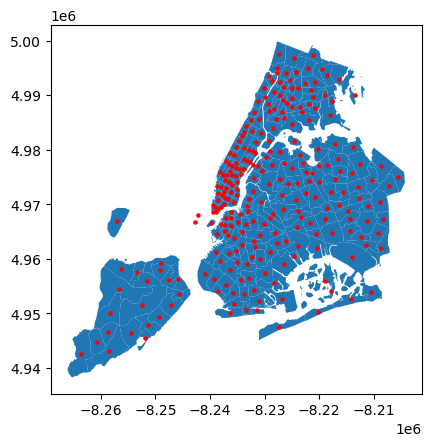

In [146]:
#plotting to visually check projected accuracy
geo_zone_proj.plot()
geo_zone_proj['centroid'].plot(ax=plt.gca(), color='red', markersize=5)
plt.show()

In [147]:
geo_zone_proj['centroid'].head()

0    POINT (-8257011.847 4966992.844)
1    POINT (-8218862.517 4955975.362)
2     POINT (-8220657.463 4992372.04)
3    POINT (-8235078.417 4971680.104)
4    POINT (-8258624.297 4946581.381)
Name: centroid, dtype: geometry

In [148]:
# the zone IDs are 1 less than they really are since they were created off index, adding +1 to all
#for index, row in distance_result_df.iterrows():
    #distance_result_df.loc[index, ['PULocationID']] = (row['PULocationID'] + 1)
    #distance_result_df.loc[index, ['DOLocationID']] = (row['DOLocationID'] + 1)

In [149]:
#display(distance_result_df.head(20))
#display(distance_result_df.tail(20))

In [150]:
#loading in the cab dfs from urls as to not bloat filesize

jan_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet')
feb_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet')
mar_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-03.parquet')
apr_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-04.parquet')
may_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-05.parquet')
jun_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-06.parquet')
jul_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-07.parquet')
aug_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-08.parquet')
sep_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-09.parquet')
oct_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-10.parquet')
nov_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-11.parquet')
dec_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-12.parquet')


In [151]:
jan_df.head(20)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.00,0.5,0.00,0.00,1.0,22.70,2.5,0.00
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.50,0.5,3.75,0.00,1.0,18.75,2.5,0.00
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.50,0.5,3.00,0.00,1.0,31.30,2.5,0.00
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.50,0.5,2.00,0.00,1.0,17.00,2.5,0.00
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.50,0.5,3.20,0.00,1.0,16.10,2.5,0.00
5,1,2024-01-01 00:54:08,2024-01-01 01:26:31,1.0,4.70,1.0,N,148,141,1,29.6,3.50,0.5,6.90,0.00,1.0,41.50,2.5,0.00
6,2,2024-01-01 00:49:44,2024-01-01 01:15:47,2.0,10.82,1.0,N,138,181,1,45.7,6.00,0.5,10.00,0.00,1.0,64.95,0.0,1.75
7,1,2024-01-01 00:30:40,2024-01-01 00:58:40,0.0,3.00,1.0,N,246,231,2,25.4,3.50,0.5,0.00,0.00,1.0,30.40,2.5,0.00
8,2,2024-01-01 00:26:01,2024-01-01 00:54:12,1.0,5.44,1.0,N,161,261,2,31.0,1.00,0.5,0.00,0.00,1.0,36.00,2.5,0.00
9,2,2024-01-01 00:28:08,2024-01-01 00:29:16,1.0,0.04,1.0,N,113,113,2,3.0,1.00,0.5,0.00,0.00,1.0,8.00,2.5,0.00


In [152]:
#combining all of the dfs

dfs = [jan_df, feb_df, mar_df, apr_df, may_df, jun_df, jul_df, aug_df, sep_df, oct_df, nov_df, dec_df]

ny_taxi_2024_df = pd.concat(dfs)

In [153]:
print(f'{len(ny_taxi_2024_df):,.2f}')

41,169,720.00


In [154]:
#checking values
display(ny_taxi_2024_df.head(10))
display(ny_taxi_2024_df.tail(10))

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.00
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.00
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.00
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.00
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.00
5,1,2024-01-01 00:54:08,2024-01-01 01:26:31,1.0,4.70,1.0,N,148,141,1,29.6,3.5,0.5,6.90,0.0,1.0,41.50,2.5,0.00
6,2,2024-01-01 00:49:44,2024-01-01 01:15:47,2.0,10.82,1.0,N,138,181,1,45.7,6.0,0.5,10.00,0.0,1.0,64.95,0.0,1.75
7,1,2024-01-01 00:30:40,2024-01-01 00:58:40,0.0,3.00,1.0,N,246,231,2,25.4,3.5,0.5,0.00,0.0,1.0,30.40,2.5,0.00
8,2,2024-01-01 00:26:01,2024-01-01 00:54:12,1.0,5.44,1.0,N,161,261,2,31.0,1.0,0.5,0.00,0.0,1.0,36.00,2.5,0.00
9,2,2024-01-01 00:28:08,2024-01-01 00:29:16,1.0,0.04,1.0,N,113,113,2,3.0,1.0,0.5,0.00,0.0,1.0,8.00,2.5,0.00


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
3668361,1,2024-12-31 23:21:36,2024-12-31 23:32:10,NaN,1.60,NaN,None,188,61,0,13.28,0.0,0.5,0.00,0.00,1.0,14.78,NaN,NaN
3668362,2,2024-12-31 23:02:30,2024-12-31 23:23:16,NaN,2.47,NaN,None,37,37,0,-0.90,0.0,0.5,0.00,0.00,1.0,0.60,NaN,NaN
3668363,2,2024-12-31 23:04:03,2024-12-31 23:14:58,NaN,1.96,NaN,None,137,79,0,-7.72,0.0,0.5,0.00,0.00,1.0,-3.72,NaN,NaN
3668364,1,2024-12-31 23:14:53,2024-12-31 23:35:13,NaN,2.90,NaN,None,145,164,0,21.94,0.0,0.5,0.00,6.94,1.0,32.88,NaN,NaN
3668365,2,2024-12-31 23:04:32,2024-12-31 23:19:51,NaN,2.49,NaN,None,37,36,0,-0.38,0.0,0.5,0.00,0.00,1.0,6.12,NaN,NaN
3668366,2,2024-12-31 23:32:00,2024-12-31 23:56:00,NaN,10.71,NaN,None,16,7,0,-4.13,0.0,0.5,0.00,0.00,1.0,-2.63,NaN,NaN
3668367,2,2024-12-31 23:05:00,2024-12-31 23:18:00,NaN,4.56,NaN,None,252,16,0,-1.68,0.0,0.5,0.00,0.00,1.0,-0.18,NaN,NaN
3668368,2,2024-12-31 23:03:16,2024-12-31 23:28:35,NaN,3.94,NaN,None,181,255,0,4.46,0.0,0.5,5.19,0.00,1.0,11.15,NaN,NaN
3668369,1,2024-12-31 23:15:33,2024-12-31 23:36:29,NaN,4.20,NaN,None,165,61,0,27.07,0.0,0.5,0.00,0.00,1.0,28.57,NaN,NaN
3668370,2,2024-12-31 23:04:36,2024-12-31 23:33:34,NaN,5.76,NaN,None,225,114,0,2.17,0.0,0.5,0.00,0.00,1.0,6.17,NaN,NaN


In [155]:
ny_taxi_2024_df['RatecodeID'].value_counts()

RatecodeID
1.0     34651027
2.0      1406870
99.0      466974
5.0       321948
3.0       129951
4.0       101642
6.0           76
Name: count, dtype: int64

In [156]:
#checking for % of nulls in each column
for column in ny_taxi_2024_df:

    print(ny_taxi_2024_df[column].isna().sum()/len(ny_taxi_2024_df[column]))

0.0
0.0
0.0
0.09937478321445956
0.0
0.09937478321445956
0.09937478321445956
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.09937478321445956
0.09937478321445956


In [157]:
ny_taxi_2024_df['passenger_count'].isna().sum()/len(ny_taxi_2024_df['passenger_count'])

0.09937478321445956

In [158]:
ny_taxi_2024_df['RatecodeID'].isna().sum()/len(ny_taxi_2024_df['RatecodeID'])

0.09937478321445956

In [159]:
ny_taxi_2024_df['congestion_surcharge'].isna().sum()/len(ny_taxi_2024_df['congestion_surcharge'])

0.09937478321445956

In [160]:
ny_taxi_2024_df['Airport_fee'].isna().sum()/len(ny_taxi_2024_df['Airport_fee'])

0.09937478321445956

In [161]:
ny_taxi_2024_df['store_and_fwd_flag'].isna().sum()/len(ny_taxi_2024_df['store_and_fwd_flag'])

0.09937478321445956

In [162]:
ny_taxi_2024_df.dtypes

VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
dtype: object

In [163]:
ny_taxi_2024_df['store_and_fwd_flag'].value_counts()

store_and_fwd_flag
N    36903316
Y      175172
Name: count, dtype: int64

In [164]:
# we decided as a gorup to simply drop all NaNs instead of trying to impute them
ny_taxi_2024_df = ny_taxi_2024_df.dropna()

In [165]:
ny_taxi_2024_df['passenger_count'].value_counts()

passenger_count
1.0    28632703
2.0     5410774
3.0     1282073
4.0      814889
0.0      401354
5.0      320613
6.0      215798
8.0         192
7.0          56
9.0          36
Name: count, dtype: int64

In [166]:
#dropping negatives
def impute_negatives(ny_taxi_2024_df):
    negatives = ['fare_amount', 'extra', 'tip_amount', 'tolls_amount', 'mta_tax', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee']
    mask = (ny_taxi_2024_df[negatives] < 0).any(axis=1)
    
    return ny_taxi_2024_df.drop(ny_taxi_2024_df[mask].index, inplace=True)

In [167]:
impute_negatives(ny_taxi_2024_df)

In [168]:
# fixing the null and 0 entries to be 1
def impute_passenger_count(ny_taxi_2024_df):
    #ny_taxi_2024_df['passenger_count'] = ny_taxi_2024_df['passenger_count'].fillna(1)
    pass_mask = (ny_taxi_2024_df['passenger_count'] == 0)

    ny_taxi_2024_df.loc[pass_mask, 'passenger_count'] = 1

    return ny_taxi_2024_df


In [169]:
impute_passenger_count(ny_taxi_2024_df)

ny_taxi_2024_df['passenger_count'].value_counts()

passenger_count
1.0    24076127
2.0     4473137
3.0     1058771
4.0      668036
5.0      269004
6.0      181125
8.0         157
7.0          43
9.0          35
Name: count, dtype: int64

In [170]:
ny_taxi_2024_df.tail(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
3342070,2,2024-12-31 23:20:13,2024-12-31 23:27:22,1.0,1.03,1.0,N,239,143,1,8.6,1.0,0.5,1.36,0.0,1.0,14.96,2.5,0.00
3342071,2,2024-12-31 23:29:45,2024-12-31 23:53:15,1.0,3.31,1.0,N,143,262,1,21.9,1.0,0.5,5.38,0.0,1.0,32.28,2.5,0.00
3342072,2,2024-12-31 23:28:26,2024-12-31 23:48:57,2.0,3.13,1.0,N,170,143,1,19.8,1.0,0.5,4.00,0.0,1.0,28.80,2.5,0.00
3342073,2,2024-12-31 23:51:36,2025-01-01 00:12:31,2.0,3.42,1.0,N,142,262,2,21.2,1.0,0.5,0.00,0.0,1.0,26.20,2.5,0.00
3342074,2,2024-12-31 23:36:13,2024-12-31 23:50:34,1.0,2.01,1.0,N,162,79,1,14.9,1.0,0.5,3.98,0.0,1.0,23.88,2.5,0.00
3342075,2,2024-12-31 22:56:33,2024-12-31 23:05:57,1.0,1.90,1.0,N,237,262,1,12.1,1.0,0.5,1.88,0.0,1.0,18.98,2.5,0.00
3342076,2,2024-12-31 23:18:37,2024-12-31 23:32:32,1.0,3.88,1.0,N,237,226,2,19.1,1.0,0.5,0.00,0.0,1.0,24.10,2.5,0.00
3342077,2,2024-12-31 23:08:52,2024-12-31 23:34:59,1.0,5.53,1.0,N,142,255,1,29.6,1.0,0.5,2.00,0.0,1.0,36.60,2.5,0.00
3342078,2,2024-12-31 23:15:55,2024-12-31 23:24:24,1.0,0.89,1.0,N,43,48,1,9.3,1.0,0.5,2.14,0.0,1.0,16.44,2.5,0.00
3342079,2,2024-12-31 23:13:22,2024-12-31 23:49:57,1.0,20.49,1.0,N,132,33,1,77.9,1.0,0.5,10.00,0.0,1.0,92.15,0.0,1.75


In [171]:
#to ensure proper application of airport fee, check location IDs containing 'airport'
def find_airport_zones_vectorized(taxi_zone_df):
    airport_mask = taxi_zone_df['Zone'].str.contains('Airport', case=False, na=False)
    airport_rows = taxi_zone_df[airport_mask].to_dict(orient='records')
    return airport_rows

In [172]:
find_airport_zones_vectorized(taxi_zone_df)

[{'LocationID': 1,
  'Borough': 'EWR',
  'Zone': 'Newark Airport',
  'service_zone': 'EWR'},
 {'LocationID': 132,
  'Borough': 'Queens',
  'Zone': 'JFK Airport',
  'service_zone': 'Airports'},
 {'LocationID': 138,
  'Borough': 'Queens',
  'Zone': 'LaGuardia Airport',
  'service_zone': 'Airports'}]

In [173]:
ny_taxi_2024_df['Airport_fee'].value_counts()

Airport_fee
0.00    28017853
1.75     2708561
1.25          21
Name: count, dtype: int64

In [174]:
#only charge 1.75 for PU at JFK or LGA, fix negatives
def impute_airport_fee(ny_taxi_2024_df):
    
    pu_mask = (ny_taxi_2024_df['PULocationID'] == 132) | (ny_taxi_2024_df['PULocationID'] == 138)
    fee_mask = np.isnan(ny_taxi_2024_df['Airport_fee']) | (ny_taxi_2024_df['Airport_fee'] == 1.25) | (ny_taxi_2024_df['Airport_fee'] == 0)
    mask = pu_mask & fee_mask
    ny_taxi_2024_df.loc[mask, 'Airport_fee'] = 1.75
    return ny_taxi_2024_df

In [175]:
impute_airport_fee(ny_taxi_2024_df)

ny_taxi_2024_df['Airport_fee'].value_counts()

Airport_fee
0.00    27936244
1.75     2790188
1.25           3
Name: count, dtype: int64

In [176]:
#still odd values, this means airport fee has been charged to PU IDs that it shouldnt have
def impute_outliers_airport_fee(ny_taxi_2024_df):
    
    pu_mask = (
        ny_taxi_2024_df['PULocationID'] != 132) & (
        ny_taxi_2024_df['PULocationID'] != 138) 
    fee_mask = np.isnan(
        ny_taxi_2024_df['Airport_fee']) | (
        ny_taxi_2024_df['Airport_fee'] == 1.25) | (ny_taxi_2024_df['Airport_fee'] == 1.75)
    mask = pu_mask & fee_mask
    ny_taxi_2024_df.loc[mask, 'Airport_fee'] = 0
    return ny_taxi_2024_df

In [177]:
impute_outliers_airport_fee(ny_taxi_2024_df)

ny_taxi_2024_df['Airport_fee'].value_counts()

Airport_fee
0.00    28052949
1.75     2673486
Name: count, dtype: int64

In [178]:
ny_taxi_2024_df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee'],
      dtype='object')

In [179]:
for column in ny_taxi_2024_df:

    print(ny_taxi_2024_df[column].isna().sum()/len(ny_taxi_2024_df[column]))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [180]:
ny_taxi_2024_df.tail(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
3342070,2,2024-12-31 23:20:13,2024-12-31 23:27:22,1.0,1.03,1.0,N,239,143,1,8.6,1.0,0.5,1.36,0.0,1.0,14.96,2.5,0.00
3342071,2,2024-12-31 23:29:45,2024-12-31 23:53:15,1.0,3.31,1.0,N,143,262,1,21.9,1.0,0.5,5.38,0.0,1.0,32.28,2.5,0.00
3342072,2,2024-12-31 23:28:26,2024-12-31 23:48:57,2.0,3.13,1.0,N,170,143,1,19.8,1.0,0.5,4.00,0.0,1.0,28.80,2.5,0.00
3342073,2,2024-12-31 23:51:36,2025-01-01 00:12:31,2.0,3.42,1.0,N,142,262,2,21.2,1.0,0.5,0.00,0.0,1.0,26.20,2.5,0.00
3342074,2,2024-12-31 23:36:13,2024-12-31 23:50:34,1.0,2.01,1.0,N,162,79,1,14.9,1.0,0.5,3.98,0.0,1.0,23.88,2.5,0.00
3342075,2,2024-12-31 22:56:33,2024-12-31 23:05:57,1.0,1.90,1.0,N,237,262,1,12.1,1.0,0.5,1.88,0.0,1.0,18.98,2.5,0.00
3342076,2,2024-12-31 23:18:37,2024-12-31 23:32:32,1.0,3.88,1.0,N,237,226,2,19.1,1.0,0.5,0.00,0.0,1.0,24.10,2.5,0.00
3342077,2,2024-12-31 23:08:52,2024-12-31 23:34:59,1.0,5.53,1.0,N,142,255,1,29.6,1.0,0.5,2.00,0.0,1.0,36.60,2.5,0.00
3342078,2,2024-12-31 23:15:55,2024-12-31 23:24:24,1.0,0.89,1.0,N,43,48,1,9.3,1.0,0.5,2.14,0.0,1.0,16.44,2.5,0.00
3342079,2,2024-12-31 23:13:22,2024-12-31 23:49:57,1.0,20.49,1.0,N,132,33,1,77.9,1.0,0.5,10.00,0.0,1.0,92.15,0.0,1.75


In [181]:
ny_taxi_2024_df['RatecodeID'].value_counts()

RatecodeID
1.0     28738978
2.0      1149864
99.0      393394
5.0       259432
3.0       103330
4.0        81375
6.0           62
Name: count, dtype: int64

In [182]:
ny_taxi_2024_df[ny_taxi_2024_df['RatecodeID'] == 4].head(20)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
177,2,2024-01-01 00:16:21,2024-01-01 00:46:36,1.0,23.00,4.0,N,70,265,2,125.5,6.00,0.5,0.00,0.00,1.0,134.75,0.0,0.00
1035,2,2024-01-01 00:47:05,2024-01-01 01:03:14,3.0,4.18,4.0,N,48,265,2,22.6,1.00,0.0,0.00,12.75,1.0,37.35,0.0,0.00
1316,2,2024-01-01 00:00:11,2024-01-01 00:42:33,1.0,9.89,4.0,N,234,265,2,81.4,1.00,0.0,0.00,12.75,1.0,96.15,0.0,0.00
2702,2,2024-01-01 00:48:30,2024-01-01 01:09:02,1.0,15.79,4.0,N,132,16,4,91.9,1.00,0.5,0.00,0.00,1.0,96.15,0.0,1.75
3508,2,2024-01-01 00:24:30,2024-01-01 01:13:09,1.0,27.08,4.0,N,163,265,1,138.8,1.00,0.5,29.37,3.05,1.0,176.22,2.5,0.00
3600,2,2024-01-01 00:35:44,2024-01-01 01:19:49,2.0,36.75,4.0,N,138,265,1,220.7,6.00,0.5,45.64,0.00,1.0,275.59,0.0,1.75
3906,2,2024-01-01 00:47:53,2024-01-01 01:29:06,4.0,26.71,4.0,N,170,265,2,125.5,1.00,0.5,0.00,6.94,1.0,137.44,2.5,0.00
4450,1,2024-01-01 00:45:29,2024-01-01 01:01:01,1.0,6.50,4.0,N,132,265,1,31.0,2.75,0.5,7.05,0.00,1.0,42.30,0.0,1.75
4912,2,2024-01-01 00:35:57,2024-01-01 01:22:32,1.0,41.20,4.0,N,132,265,2,201.8,1.00,0.5,0.00,6.94,1.0,212.99,0.0,1.75
5169,2,2024-01-01 00:30:56,2024-01-01 00:43:52,1.0,6.02,4.0,N,132,265,2,28.2,1.00,0.5,0.00,0.00,1.0,34.95,2.5,1.75


In [183]:
#ratecode depends on location of either standard, or JFK|Newark|Nassau|Westchester, finding the zone ids
def find_ratecode_zones_vectorized(taxi_zone_df):
    pattern = r'JFK|Newark|Nassau|Westchester'
    ratecode_rows = taxi_zone_df['Zone'].str.contains(pattern, case=False, na=False)
    ratecode_rows = taxi_zone_df[ratecode_rows].to_dict(orient='records')
    return ratecode_rows

In [184]:
taxi_zone_df[taxi_zone_df['Zone'].str.contains('Nassau', case=False, na=False)].head()

,LocationID,Borough,Zone,service_zone


In [185]:
find_ratecode_zones_vectorized(taxi_zone_df)

[{'LocationID': 1,
  'Borough': 'EWR',
  'Zone': 'Newark Airport',
  'service_zone': 'EWR'},
 {'LocationID': 132,
  'Borough': 'Queens',
  'Zone': 'JFK Airport',
  'service_zone': 'Airports'},
 {'LocationID': 250,
  'Borough': 'Bronx',
  'Zone': 'Westchester Village/Unionport',
  'service_zone': 'Boro Zone'}]

In [186]:
#imputing anything that should be a 1 / nulls to a 1 (standard)
def impute_na_ratecodeID(ny_taxi_2024_df):
    def_mask = (ny_taxi_2024_df['PULocationID'] != ny_taxi_2024_df['PULocationID'].isin([np.isnan, 1, 132, 250, 265])) | (
        ny_taxi_2024_df['DOLocationID'] != ny_taxi_2024_df['DOLocationID'].isin([np.isnan, 1, 132, 250, 265])
    )
    rate_mask = (ny_taxi_2024_df['RatecodeID'] > 6) | np.isnan(ny_taxi_2024_df['RatecodeID'])
    mask = def_mask & rate_mask
    ny_taxi_2024_df.loc[mask, ['RatecodeID']] = 1
    return ny_taxi_2024_df

In [187]:
impute_na_ratecodeID(ny_taxi_2024_df)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.00
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.00
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.00
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.00
5,1,2024-01-01 00:54:08,2024-01-01 01:26:31,1.0,4.70,1.0,N,148,141,1,29.6,3.5,0.5,6.90,0.0,1.0,41.50,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3342075,2,2024-12-31 22:56:33,2024-12-31 23:05:57,1.0,1.90,1.0,N,237,262,1,12.1,1.0,0.5,1.88,0.0,1.0,18.98,2.5,0.00
3342076,2,2024-12-31 23:18:37,2024-12-31 23:32:32,1.0,3.88,1.0,N,237,226,2,19.1,1.0,0.5,0.00,0.0,1.0,24.10,2.5,0.00
3342077,2,2024-12-31 23:08:52,2024-12-31 23:34:59,1.0,5.53,1.0,N,142,255,1,29.6,1.0,0.5,2.00,0.0,1.0,36.60,2.5,0.00
3342078,2,2024-12-31 23:15:55,2024-12-31 23:24:24,1.0,0.89,1.0,N,43,48,1,9.3,1.0,0.5,2.14,0.0,1.0,16.44,2.5,0.00


In [188]:
ny_taxi_2024_df['RatecodeID'].value_counts()

RatecodeID
1.0    29132372
2.0     1149864
5.0      259432
3.0      103330
4.0       81375
6.0          62
Name: count, dtype: int64

In [189]:
#imputing correct ratecode ID to locations corresponding ratecode
def impute_ratecodeIDs(ny_taxi_2024_df):
    mask = (ny_taxi_2024_df['PULocationID'] == 1) | (ny_taxi_2024_df['DOLocationID'] == 1)
    mask_2 = (ny_taxi_2024_df['PULocationID'] == 132) | (ny_taxi_2024_df['DOLocationID'] == 132)
    mask_3 = (ny_taxi_2024_df['PULocationID'] == 250) | (ny_taxi_2024_df['DOLocationID'] == 250) | (
        ny_taxi_2024_df['PULocationID'] == 265) | (ny_taxi_2024_df['DOLocationID'] == 265)
    ny_taxi_2024_df.loc[mask, ['RatecodeID']] = 3
    ny_taxi_2024_df.loc[mask_2, ['RatecodeID']] = 2
    ny_taxi_2024_df.loc[mask_3, ['RatecodeID']] = 4
    return ny_taxi_2024_df
    

In [190]:
impute_ratecodeIDs(ny_taxi_2024_df)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.00
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.00
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.00
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.00
5,1,2024-01-01 00:54:08,2024-01-01 01:26:31,1.0,4.70,1.0,N,148,141,1,29.6,3.5,0.5,6.90,0.0,1.0,41.50,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3342075,2,2024-12-31 22:56:33,2024-12-31 23:05:57,1.0,1.90,1.0,N,237,262,1,12.1,1.0,0.5,1.88,0.0,1.0,18.98,2.5,0.00
3342076,2,2024-12-31 23:18:37,2024-12-31 23:32:32,1.0,3.88,1.0,N,237,226,2,19.1,1.0,0.5,0.00,0.0,1.0,24.10,2.5,0.00
3342077,2,2024-12-31 23:08:52,2024-12-31 23:34:59,1.0,5.53,1.0,N,142,255,1,29.6,1.0,0.5,2.00,0.0,1.0,36.60,2.5,0.00
3342078,2,2024-12-31 23:15:55,2024-12-31 23:24:24,1.0,0.89,1.0,N,43,48,1,9.3,1.0,0.5,2.14,0.0,1.0,16.44,2.5,0.00


In [191]:
ny_taxi_2024_df['RatecodeID'].value_counts()

RatecodeID
1.0    28420187
2.0     1887871
5.0      163189
4.0      154268
3.0      100873
6.0          47
Name: count, dtype: int64

In [192]:
for column in ny_taxi_2024_df:

    print(ny_taxi_2024_df[column].isna().sum()/len(ny_taxi_2024_df[column]))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [193]:
ny_taxi_2024_df['congestion_surcharge'].value_counts()

congestion_surcharge
2.50    28307617
0.00     2418787
1.00          18
0.75          11
2.00           1
2.52           1
Name: count, dtype: int64

In [194]:
ny_taxi_2024_df[ny_taxi_2024_df['congestion_surcharge'] == -0.75]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee


In [195]:
def impute_surcharge(ny_taxi_2024_df):
    nan = np.isnan(ny_taxi_2024_df['congestion_surcharge'])

    return ny_taxi_2024_df.drop(ny_taxi_2024_df[nan].index, inplace=True)

In [196]:
impute_surcharge(ny_taxi_2024_df)

In [197]:
#all negative values seem to be in rows with eachother, perhaps from an error or how the data was processed, fixing all negatives values to be their absolute value
#def impute_negatives(ny_taxi_2024_df):
    #negatives = ['fare_amount', 'extra', 'tip_amount', 'tolls_amount', 'mta_tax', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee']
    #mask = (ny_taxi_2024_df[negatives] < 0).any(axis=1)
    
    #return ny_taxi_2024_df.drop(ny_taxi_2024_df[mask].index, inplace=True)

In [198]:
#impute_negatives(ny_taxi_2024_df)

In [199]:
for column in ny_taxi_2024_df:

    print(ny_taxi_2024_df[column].isna().sum()/len(ny_taxi_2024_df[column]))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [200]:
for column in ny_taxi_2024_df:
    print(ny_taxi_2024_df[column].value_counts())

VendorID
2    23271956
1     7454279
7         200
Name: count, dtype: int64
tpep_pickup_datetime
2024-09-30 09:00:00    15
2024-11-26 11:00:00    14
2024-09-30 10:00:00    13
2024-12-05 21:28:51    13
2024-09-15 00:00:36    12
                       ..
2024-06-11 19:55:58     1
2024-06-11 19:47:39     1
2024-06-11 19:05:25     1
2024-06-11 19:57:45     1
2024-12-31 23:13:22     1
Name: count, Length: 17542695, dtype: int64
tpep_dropoff_datetime
2024-04-20 00:00:00    21
2024-07-29 00:00:00    19
2024-10-16 00:00:00    18
2024-11-28 00:00:00    17
2024-12-22 00:00:00    17
                       ..
2024-06-11 17:54:37     1
2024-06-11 17:22:31     1
2024-06-11 17:37:26     1
2024-06-11 18:09:53     1
2024-12-31 23:49:57     1
Name: count, Length: 17523511, dtype: int64
passenger_count
1.0    24076127
2.0     4473137
3.0     1058771
4.0      668036
5.0      269004
6.0      181125
8.0         157
7.0          43
9.0          35
Name: count, dtype: int64
trip_distance
0.90      410899
1.0

In [201]:
ny_taxi_2024_df[ny_taxi_2024_df['trip_distance'] == 223463.68]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee


In [202]:
def trip_distance_weird_maxes(ny_taxi_2024_df):
    long = (ny_taxi_2024_df['trip_distance'] > 75)
    
    return ny_taxi_2024_df.drop(ny_taxi_2024_df[long].index, inplace=True)

In [203]:
trip_distance_weird_maxes(ny_taxi_2024_df)

ny_taxi_2024_df['trip_distance'].value_counts()

trip_distance
0.90     410732
1.00     407028
0.80     403796
1.10     393603
0.00     381791
          ...  
71.96         1
43.56         1
74.35         1
60.18         1
55.05         1
Name: count, Length: 6605, dtype: int64

In [204]:
ny_taxi_2024_df[ny_taxi_2024_df['trip_distance'] == 197.97]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee


In [205]:
ny_taxi_2024_df[ny_taxi_2024_df['trip_distance'] == 67.32]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
266673,2,2024-01-04 15:23:03,2024-01-04 17:20:56,4.0,67.32,4.0,N,132,265,1,350.0,0.0,0.0,10.0,6.94,1.0,369.69,0.0,1.75


In [206]:
ny_taxi_2024_df[ny_taxi_2024_df['trip_distance'] > 50]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
16093,2,2024-01-01 02:37:39,2024-01-01 04:25:31,1.0,54.81,4.0,N,158,265,2,299.1,1.0,0.5,0.00,13.88,1.0,317.98,2.5,0.00
25906,2,2024-01-01 08:09:04,2024-01-01 09:18:26,1.0,60.93,4.0,N,132,265,1,150.0,0.0,0.0,33.50,14.75,1.0,201.00,0.0,1.75
29432,2,2024-01-01 10:42:19,2024-01-01 11:35:08,1.0,51.83,4.0,N,230,265,1,357.9,0.0,0.0,0.00,12.75,1.0,371.65,0.0,0.00
38746,2,2024-01-01 13:24:51,2024-01-01 14:44:45,2.0,53.23,3.0,N,163,138,1,214.8,5.0,0.0,1.00,35.74,1.0,257.54,0.0,0.00
38929,2,2024-01-01 13:30:08,2024-01-01 14:55:11,1.0,67.84,4.0,N,132,265,4,404.1,0.0,0.0,0.00,19.69,1.0,426.54,0.0,1.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3294999,2,2024-12-31 14:03:28,2024-12-31 15:25:04,1.0,60.00,4.0,N,132,265,1,430.0,0.0,0.0,0.20,34.26,1.0,467.21,0.0,1.75
3312085,2,2024-12-31 17:41:59,2024-12-31 19:15:03,1.0,70.79,4.0,N,132,265,4,436.3,2.5,0.5,0.00,6.94,1.0,448.99,0.0,1.75
3322588,2,2024-12-31 20:37:30,2024-12-31 22:16:33,4.0,71.03,4.0,N,132,265,1,275.0,0.0,0.0,15.00,13.38,1.0,304.38,0.0,1.75
3326619,2,2024-12-31 20:07:03,2024-12-31 21:11:52,1.0,55.05,4.0,N,138,265,1,197.6,6.0,0.5,51.27,0.00,1.0,258.12,0.0,1.75


In [207]:
ny_taxi_2024_df[ny_taxi_2024_df['fare_amount'] < 50]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0
5,1,2024-01-01 00:54:08,2024-01-01 01:26:31,1.0,4.70,1.0,N,148,141,1,29.6,3.5,0.5,6.90,0.0,1.0,41.50,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3342074,2,2024-12-31 23:36:13,2024-12-31 23:50:34,1.0,2.01,1.0,N,162,79,1,14.9,1.0,0.5,3.98,0.0,1.0,23.88,2.5,0.0
3342075,2,2024-12-31 22:56:33,2024-12-31 23:05:57,1.0,1.90,1.0,N,237,262,1,12.1,1.0,0.5,1.88,0.0,1.0,18.98,2.5,0.0
3342076,2,2024-12-31 23:18:37,2024-12-31 23:32:32,1.0,3.88,1.0,N,237,226,2,19.1,1.0,0.5,0.00,0.0,1.0,24.10,2.5,0.0
3342077,2,2024-12-31 23:08:52,2024-12-31 23:34:59,1.0,5.53,1.0,N,142,255,1,29.6,1.0,0.5,2.00,0.0,1.0,36.60,2.5,0.0


In [208]:
# do we even want the data of trips coming from or going out of NY? i.e zone 265? dropping

def drop_unknowns(ny_taxi_2024_df):
    drop_rows = (ny_taxi_2024_df['PULocationID'] == 265) | (ny_taxi_2024_df['DOLocationID'] == 265) | (
        ny_taxi_2024_df['PULocationID'] == 264) | (ny_taxi_2024_df['DOLocationID'] == 264
    ) | (ny_taxi_2024_df['payment_type'] == 3) | (ny_taxi_2024_df['payment_type'] == 5) | (
        ny_taxi_2024_df['payment_type'] == 6
    )
    return ny_taxi_2024_df.drop(ny_taxi_2024_df[drop_rows].index, inplace=True)


In [209]:
drop_unknowns(ny_taxi_2024_df)

In [210]:
for column in ny_taxi_2024_df:

    print(ny_taxi_2024_df[column].isna().sum()/len(ny_taxi_2024_df[column]))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [211]:
ny_taxi_2024_df.dtypes

VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
dtype: object

In [212]:
ny_taxi_2024_df['trip_distance'].value_counts()

trip_distance
0.90     337641
1.00     335119
0.80     331988
1.10     323905
1.20     311481
          ...  
42.78         1
39.69         1
49.02         1
60.50         1
41.00         1
Name: count, Length: 4393, dtype: int64

In [213]:
ny_taxi_2024_df[ny_taxi_2024_df['trip_distance'] == 206.30]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee


In [214]:
len(ny_taxi_2024_df)

25401141

In [215]:
#impute for binary, however going to drop this row
def impute_store_and_fwd_flag(ny_taxi_2024_df):
    no_mask = (ny_taxi_2024_df['store_and_fwd_flag'] == 'N')
    yes_mask = (ny_taxi_2024_df['store_and_fwd_flag'] == 'Y')

    ny_taxi_2024_df.loc[no_mask, ['store_and_fwd_flag']] = 0
    ny_taxi_2024_df.loc[yes_mask, ['store_and_fwd_flag']] = 1

    return ny_taxi_2024_df

In [216]:
impute_store_and_fwd_flag(ny_taxi_2024_df)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
5,1,2024-01-01 00:54:08,2024-01-01 01:26:31,1.0,4.70,1.0,0,148,141,1,29.6,3.5,0.5,6.90,0.00,1.0,41.50,2.5,0.00
8,2,2024-01-01 00:26:01,2024-01-01 00:54:12,1.0,5.44,1.0,0,161,261,2,31.0,1.0,0.5,0.00,0.00,1.0,36.00,2.5,0.00
9,2,2024-01-01 00:28:08,2024-01-01 00:29:16,1.0,0.04,1.0,0,113,113,2,3.0,1.0,0.5,0.00,0.00,1.0,8.00,2.5,0.00
11,1,2024-01-01 00:25:00,2024-01-01 00:34:03,2.0,1.20,1.0,0,158,246,1,14.9,3.5,0.5,3.95,0.00,1.0,23.85,2.5,0.00
12,1,2024-01-01 00:35:16,2024-01-01 01:11:52,2.0,8.20,1.0,0,246,190,1,59.0,3.5,0.5,14.15,6.94,1.0,85.09,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3342075,2,2024-12-31 22:56:33,2024-12-31 23:05:57,1.0,1.90,1.0,0,237,262,1,12.1,1.0,0.5,1.88,0.00,1.0,18.98,2.5,0.00
3342076,2,2024-12-31 23:18:37,2024-12-31 23:32:32,1.0,3.88,1.0,0,237,226,2,19.1,1.0,0.5,0.00,0.00,1.0,24.10,2.5,0.00
3342077,2,2024-12-31 23:08:52,2024-12-31 23:34:59,1.0,5.53,1.0,0,142,255,1,29.6,1.0,0.5,2.00,0.00,1.0,36.60,2.5,0.00
3342078,2,2024-12-31 23:15:55,2024-12-31 23:24:24,1.0,0.89,1.0,0,43,48,1,9.3,1.0,0.5,2.14,0.00,1.0,16.44,2.5,0.00


In [217]:
ny_taxi_2024_df['store_and_fwd_flag'].value_counts()

store_and_fwd_flag
0    25287992
1      113149
Name: count, dtype: int64

In [218]:
ny_taxi_2024_df[ny_taxi_2024_df['passenger_count'] >= 4]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
36,1,2024-01-01 00:39:03,2024-01-01 00:44:28,4.0,1.10,1.0,0,236,238,1,7.9,3.5,0.5,0.00,0.00,1.0,12.90,2.5,0.00
45,2,2024-01-01 00:45:44,2024-01-01 00:51:25,4.0,1.04,1.0,0,142,163,2,7.9,1.0,0.5,0.00,0.00,1.0,12.90,2.5,0.00
46,2,2024-01-01 00:55:21,2024-01-01 01:12:17,4.0,2.41,1.0,0,163,140,1,17.7,1.0,0.5,4.54,0.00,1.0,27.24,2.5,0.00
76,2,2024-01-01 00:14:52,2024-01-01 00:17:38,5.0,0.55,1.0,0,239,143,1,5.1,1.0,0.5,1.52,0.00,1.0,11.62,2.5,0.00
77,2,2024-01-01 00:22:06,2024-01-01 00:51:28,5.0,3.10,1.0,0,143,170,1,26.8,1.0,0.5,6.36,0.00,1.0,38.16,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3342015,2,2024-12-31 23:21:38,2024-12-31 23:40:31,4.0,1.97,1.0,0,107,48,1,17.7,1.0,0.5,4.54,0.00,1.0,27.24,2.5,0.00
3342017,2,2024-12-31 23:38:22,2025-01-01 00:08:38,4.0,6.58,1.0,0,186,40,1,35.2,1.0,0.5,0.00,6.94,1.0,47.14,2.5,0.00
3342053,2,2024-12-31 23:27:21,2024-12-31 23:43:34,4.0,7.05,2.0,0,132,63,2,28.9,1.0,0.5,0.00,0.00,1.0,35.65,2.5,1.75
3342054,2,2024-12-31 23:51:33,2025-01-01 00:11:56,5.0,4.70,1.0,0,48,231,1,23.3,1.0,0.5,5.66,0.00,1.0,33.96,2.5,0.00


In [219]:
ny_taxi_2024_df[ny_taxi_2024_df['payment_type'] == 4]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
100,2,2024-01-01 00:18:24,2024-01-01 00:30:39,1.0,2.16,1.0,0,249,232,4,13.5,1.00,0.5,0.0,0.0,1.0,18.50,2.5,0.00
504,1,2024-01-01 00:13:32,2024-01-01 00:44:40,1.0,10.40,2.0,0,132,61,4,41.5,2.75,0.5,0.0,0.0,1.0,45.75,0.0,1.75
537,2,2024-01-01 00:41:42,2024-01-01 00:46:00,1.0,0.47,1.0,0,249,113,4,5.8,1.00,0.5,0.0,0.0,1.0,10.80,2.5,0.00
854,1,2024-01-01 00:27:42,2024-01-01 00:28:49,1.0,0.20,1.0,0,239,143,4,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00
1000,2,2024-01-01 00:14:22,2024-01-01 00:21:53,1.0,1.17,1.0,0,170,161,4,9.3,1.00,0.5,0.0,0.0,1.0,14.30,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3341960,2,2024-12-31 23:51:07,2025-01-01 00:01:02,3.0,1.69,1.0,0,164,68,4,11.4,1.00,0.5,0.0,0.0,1.0,16.40,2.5,0.00
3341980,1,2024-12-31 23:14:06,2024-12-31 23:30:16,1.0,1.50,1.0,0,107,246,4,13.5,3.50,0.5,0.0,0.0,1.0,18.50,2.5,0.00
3342023,2,2024-12-31 23:27:37,2024-12-31 23:28:25,2.0,0.06,1.0,0,162,162,4,3.0,1.00,0.5,0.0,0.0,1.0,8.00,2.5,0.00
3342044,2,2024-12-31 23:01:43,2024-12-31 23:05:57,1.0,0.49,1.0,0,263,236,4,5.8,1.00,0.5,0.0,0.0,1.0,10.80,2.5,0.00


In [220]:
ny_taxi_2024_df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee'],
      dtype='object')

In [221]:
ny_taxi_2024_df.tail(20)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
3342060,1,2024-12-31 23:52:43,2025-01-01 00:20:44,1.0,6.20,1.0,0,170,238,1,31.0,3.5,0.5,7.20,0.0,1.0,43.20,2.5,0.00
3342061,2,2024-12-31 23:31:27,2024-12-31 23:45:50,1.0,1.04,1.0,0,197,173,2,13.5,1.0,0.5,0.00,0.0,1.0,16.00,0.0,0.00
3342062,2,2024-12-31 23:25:24,2024-12-31 23:42:46,2.0,2.49,1.0,0,162,148,1,16.3,1.0,0.5,4.26,0.0,1.0,25.56,2.5,0.00
3342063,2,2024-12-31 23:17:58,2024-12-31 23:41:17,1.0,3.48,1.0,0,79,261,1,21.9,1.0,0.5,5.38,0.0,1.0,32.28,2.5,0.00
3342064,2,2024-12-31 23:59:45,2025-01-01 00:07:32,1.0,2.70,1.0,0,142,166,2,12.8,1.0,0.5,0.00,0.0,1.0,17.80,2.5,0.00
3342065,1,2024-12-31 23:18:26,2024-12-31 23:22:36,1.0,0.80,1.0,0,224,137,1,5.8,3.5,0.5,2.16,0.0,1.0,12.96,2.5,0.00
3342066,2,2024-12-31 23:18:03,2024-12-31 23:26:43,1.0,1.80,1.0,0,238,263,1,10.7,1.0,0.5,2.36,0.0,1.0,18.06,2.5,0.00
3342067,2,2024-12-31 23:17:11,2024-12-31 23:22:39,2.0,1.63,1.0,0,142,238,1,8.6,1.0,0.5,3.40,0.0,1.0,17.00,2.5,0.00
3342068,2,2024-12-31 23:24:58,2024-12-31 23:35:26,1.0,1.92,1.0,0,239,237,1,12.1,1.0,0.5,4.28,0.0,1.0,21.38,2.5,0.00
3342069,2,2024-12-31 23:59:25,2025-01-01 00:03:29,1.0,0.82,2.0,0,219,132,2,6.5,1.0,0.5,0.00,0.0,1.0,9.00,0.0,0.00


In [222]:
#many of the total amounts are just plain wrong. but from the ones that are right you can tell its a simple addition formula. fixing all of the total amount entries to be correct
def fix_total_amount(ny_taxi_2024_df):
    fix_1 = (ny_taxi_2024_df['fare_amount'] > ny_taxi_2024_df['total_amount'])
    fix_2 = (ny_taxi_2024_df['fare_amount'] < ny_taxi_2024_df['total_amount'])
    columns_to_sum = [
        'fare_amount',
        'extra',
        'mta_tax',
        'tolls_amount',
        'improvement_surcharge',
        'congestion_surcharge',
        'Airport_fee'
    ]
    sum_of_columns = ny_taxi_2024_df[columns_to_sum].sum(axis=1)

    fix_amount = fix_1 & fix_2
    
    ny_taxi_2024_df.loc[fix_amount, ['total_amount']] = sum_of_columns[fix_amount]
    return ny_taxi_2024_df

In [223]:
fix_total_amount(ny_taxi_2024_df)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
5,1,2024-01-01 00:54:08,2024-01-01 01:26:31,1.0,4.70,1.0,0,148,141,1,29.6,3.5,0.5,6.90,0.00,1.0,41.50,2.5,0.00
8,2,2024-01-01 00:26:01,2024-01-01 00:54:12,1.0,5.44,1.0,0,161,261,2,31.0,1.0,0.5,0.00,0.00,1.0,36.00,2.5,0.00
9,2,2024-01-01 00:28:08,2024-01-01 00:29:16,1.0,0.04,1.0,0,113,113,2,3.0,1.0,0.5,0.00,0.00,1.0,8.00,2.5,0.00
11,1,2024-01-01 00:25:00,2024-01-01 00:34:03,2.0,1.20,1.0,0,158,246,1,14.9,3.5,0.5,3.95,0.00,1.0,23.85,2.5,0.00
12,1,2024-01-01 00:35:16,2024-01-01 01:11:52,2.0,8.20,1.0,0,246,190,1,59.0,3.5,0.5,14.15,6.94,1.0,85.09,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3342075,2,2024-12-31 22:56:33,2024-12-31 23:05:57,1.0,1.90,1.0,0,237,262,1,12.1,1.0,0.5,1.88,0.00,1.0,18.98,2.5,0.00
3342076,2,2024-12-31 23:18:37,2024-12-31 23:32:32,1.0,3.88,1.0,0,237,226,2,19.1,1.0,0.5,0.00,0.00,1.0,24.10,2.5,0.00
3342077,2,2024-12-31 23:08:52,2024-12-31 23:34:59,1.0,5.53,1.0,0,142,255,1,29.6,1.0,0.5,2.00,0.00,1.0,36.60,2.5,0.00
3342078,2,2024-12-31 23:15:55,2024-12-31 23:24:24,1.0,0.89,1.0,0,43,48,1,9.3,1.0,0.5,2.14,0.00,1.0,16.44,2.5,0.00


In [224]:
ny_taxi_2024_df['service'] = 0

In [225]:
#dropping irrelavent columns that dont match with uber / lyft datasets anyways
ny_taxi_2024_df = ny_taxi_2024_df[['service', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_distance', 'fare_amount', 'tolls_amount', 'congestion_surcharge', 'Airport_fee', 'total_amount']]

In [226]:
display(ny_taxi_2024_df.head(10))
display(ny_taxi_2024_df.tail(10))

,service,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,tolls_amount,congestion_surcharge,Airport_fee,total_amount
5,0,2024-01-01 00:54:08,2024-01-01 01:26:31,148,141,4.70,29.6,0.00,2.5,0.0,41.50
8,0,2024-01-01 00:26:01,2024-01-01 00:54:12,161,261,5.44,31.0,0.00,2.5,0.0,36.00
9,0,2024-01-01 00:28:08,2024-01-01 00:29:16,113,113,0.04,3.0,0.00,2.5,0.0,8.00
11,0,2024-01-01 00:25:00,2024-01-01 00:34:03,158,246,1.20,14.9,0.00,2.5,0.0,23.85
12,0,2024-01-01 00:35:16,2024-01-01 01:11:52,246,190,8.20,59.0,6.94,2.5,0.0,85.09
16,0,2024-01-01 00:41:06,2024-01-01 00:53:42,164,79,1.50,12.8,0.00,2.5,0.0,22.25
18,0,2024-01-01 00:56:38,2024-01-01 01:03:17,141,263,1.50,9.3,0.00,2.5,0.0,17.30
20,0,2024-01-01 00:52:30,2024-01-01 00:57:37,263,236,0.66,6.5,0.00,2.5,0.0,14.38
21,0,2024-01-01 00:36:30,2024-01-01 01:13:53,246,170,1.70,29.6,0.00,2.5,0.0,41.50
22,0,2024-01-01 00:44:24,2024-01-01 00:51:57,158,113,0.94,8.6,0.00,2.5,0.0,16.32


,service,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,tolls_amount,congestion_surcharge,Airport_fee,total_amount
3342070,0,2024-12-31 23:20:13,2024-12-31 23:27:22,239,143,1.03,8.6,0.0,2.5,0.00,14.96
3342071,0,2024-12-31 23:29:45,2024-12-31 23:53:15,143,262,3.31,21.9,0.0,2.5,0.00,32.28
3342072,0,2024-12-31 23:28:26,2024-12-31 23:48:57,170,143,3.13,19.8,0.0,2.5,0.00,28.80
3342073,0,2024-12-31 23:51:36,2025-01-01 00:12:31,142,262,3.42,21.2,0.0,2.5,0.00,26.20
3342074,0,2024-12-31 23:36:13,2024-12-31 23:50:34,162,79,2.01,14.9,0.0,2.5,0.00,23.88
3342075,0,2024-12-31 22:56:33,2024-12-31 23:05:57,237,262,1.90,12.1,0.0,2.5,0.00,18.98
3342076,0,2024-12-31 23:18:37,2024-12-31 23:32:32,237,226,3.88,19.1,0.0,2.5,0.00,24.10
3342077,0,2024-12-31 23:08:52,2024-12-31 23:34:59,142,255,5.53,29.6,0.0,2.5,0.00,36.60
3342078,0,2024-12-31 23:15:55,2024-12-31 23:24:24,43,48,0.89,9.3,0.0,2.5,0.00,16.44
3342079,0,2024-12-31 23:13:22,2024-12-31 23:49:57,132,33,20.49,77.9,0.0,0.0,1.75,92.15


In [227]:
for column in ny_taxi_2024_df:

    print(ny_taxi_2024_df[column].isna().sum()/len(ny_taxi_2024_df[column]))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [228]:
ny_taxi_2024_df[ny_taxi_2024_df['Airport_fee'] > 1]

,service,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,tolls_amount,congestion_surcharge,Airport_fee,total_amount
55,0,2024-01-01 00:13:52,2024-01-01 00:29:41,138,107,8.89,35.2,6.94,2.5,1.75,64.32
98,0,2024-01-01 00:50:28,2024-01-01 01:38:39,132,26,20.34,80.0,0.00,0.0,1.75,86.25
205,0,2024-01-01 00:55:31,2024-01-01 01:21:15,132,213,18.42,68.1,6.94,0.0,1.75,79.29
229,0,2024-01-01 00:33:08,2024-01-01 00:59:55,132,141,20.59,70.0,6.94,2.5,1.75,103.36
246,0,2024-01-01 00:22:51,2024-01-01 00:41:51,138,80,8.21,33.8,0.00,0.0,1.75,53.37
...,...,...,...,...,...,...,...,...,...,...,...
3342040,0,2024-12-31 23:13:54,2024-12-31 23:39:46,132,171,14.38,54.8,0.00,0.0,1.75,65.05
3342047,0,2024-12-31 23:49:12,2025-01-01 00:10:26,132,173,9.95,40.1,0.00,2.5,1.75,46.85
3342049,0,2024-12-31 23:21:48,2024-12-31 23:38:00,132,39,9.32,36.6,0.00,2.5,1.75,43.35
3342053,0,2024-12-31 23:27:21,2024-12-31 23:43:34,132,63,7.05,28.9,0.00,2.5,1.75,35.65


In [229]:
ny_taxi_2024_df['trip_distance'].value_counts()

trip_distance
0.90     337641
1.00     335119
0.80     331988
1.10     323905
1.20     311481
          ...  
42.78         1
39.69         1
49.02         1
60.50         1
41.00         1
Name: count, Length: 4393, dtype: int64

In [230]:
ny_taxi_2024_df[ny_taxi_2024_df['trip_distance'] > 200]

,service,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,tolls_amount,congestion_surcharge,Airport_fee,total_amount


In [231]:
#merging the distance results (with every possible distance combination colculation) to the cab data, to replace trip_distance to be consistently as accurate as possible
#def fix_trip_distance(ny_taxi_2024_df, distance_result_df):
   
    #merged_df = pd.merge(
        #ny_taxi_2024_df,
        #distance_result_df,
        #left_on=['PULocationID', 'DOLocationID'],
        #right_on=['PULocationID', 'DOLocationID'],
        #how='left'  
    #)


    #ny_taxi_2024_df['trip_distance'] = round(merged_df['distance_miles'], 2)

    #return ny_taxi_2024_df

In [232]:
#fix_trip_distance(ny_taxi_2024_df, distance_result_df)

In [233]:
for column in ny_taxi_2024_df:

    print(ny_taxi_2024_df[column].isna().sum()/len(ny_taxi_2024_df[column]))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [234]:
for column in ny_taxi_2024_df:
    print(ny_taxi_2024_df[column].value_counts())

service
0    25401141
Name: count, dtype: int64
tpep_pickup_datetime
2024-12-05 21:28:51    12
2024-11-06 12:00:00    12
2024-09-30 10:00:00    12
2024-09-28 18:05:02    11
2024-03-28 15:03:00    11
                       ..
2024-03-21 14:49:06     1
2024-07-29 17:15:42     1
2024-07-29 17:31:42     1
2024-07-29 17:31:33     1
2024-12-31 23:13:22     1
Name: count, Length: 15770685, dtype: int64
tpep_dropoff_datetime
2024-07-29 00:00:00    17
2024-04-20 00:00:00    17
2024-02-09 00:00:00    15
2024-12-22 00:00:00    15
2024-11-28 00:00:00    15
                       ..
2024-07-29 17:56:33     1
2024-07-29 17:27:12     1
2024-07-29 17:56:30     1
2024-03-21 16:32:48     1
2024-12-31 23:49:57     1
Name: count, Length: 15755120, dtype: int64
PULocationID
132    1276417
237    1263237
161    1240737
236    1114912
162     936843
        ...   
176          5
84           5
105          4
5            4
99           1
Name: count, Length: 260, dtype: int64
DOLocationID
236    1174891
237 

In [235]:
jan_df.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.00
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.00
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.00
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.00
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.00
5,1,2024-01-01 00:54:08,2024-01-01 01:26:31,1.0,4.70,1.0,N,148,141,1,29.6,3.5,0.5,6.90,0.0,1.0,41.50,2.5,0.00
6,2,2024-01-01 00:49:44,2024-01-01 01:15:47,2.0,10.82,1.0,N,138,181,1,45.7,6.0,0.5,10.00,0.0,1.0,64.95,0.0,1.75
7,1,2024-01-01 00:30:40,2024-01-01 00:58:40,0.0,3.00,1.0,N,246,231,2,25.4,3.5,0.5,0.00,0.0,1.0,30.40,2.5,0.00
8,2,2024-01-01 00:26:01,2024-01-01 00:54:12,1.0,5.44,1.0,N,161,261,2,31.0,1.0,0.5,0.00,0.0,1.0,36.00,2.5,0.00
9,2,2024-01-01 00:28:08,2024-01-01 00:29:16,1.0,0.04,1.0,N,113,113,2,3.0,1.0,0.5,0.00,0.0,1.0,8.00,2.5,0.00


In [ ]:
# sampling dataset down 8% to match length of uber and lyft classes
ny_taxi_2024_df = ny_taxi_2024_df.sample(frac=0.08, random_state=29)

In [237]:
display(ny_taxi_2024_df.head(20))
display(ny_taxi_2024_df.tail(20))

,service,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,tolls_amount,congestion_surcharge,Airport_fee,total_amount
2494440,0,2024-04-25 06:24:53,2024-04-25 06:33:16,186,137,1.33,10.0,0.00,2.5,0.00,14.00
2285089,0,2024-05-21 15:51:50,2024-05-21 16:03:16,186,113,1.42,12.1,0.00,2.5,0.00,19.32
36578,0,2024-11-01 11:58:09,2024-11-01 12:30:02,68,237,2.80,24.7,0.00,2.5,0.00,35.90
2578055,0,2024-02-27 19:34:15,2024-02-27 19:46:24,230,107,2.18,14.2,0.00,2.5,0.00,23.18
1552284,0,2024-02-16 21:21:27,2024-02-16 21:36:21,161,238,3.89,19.1,0.00,2.5,0.00,28.92
929397,0,2024-03-09 21:16:46,2024-03-09 21:29:11,170,48,1.51,12.8,0.00,2.5,0.00,17.80
3322321,0,2024-10-30 22:29:18,2024-10-30 22:55:24,138,17,8.68,40.1,0.00,0.0,1.75,54.35
1009078,0,2024-11-09 23:55:24,2024-11-10 00:16:34,107,33,5.20,26.1,0.00,2.5,0.00,37.30
1243944,0,2024-09-13 13:28:01,2024-09-13 13:39:59,141,163,0.82,11.4,0.00,2.5,0.00,18.48
496807,0,2024-06-05 18:06:39,2024-06-05 18:16:16,107,137,1.25,10.0,0.00,2.5,0.00,18.98


,service,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,tolls_amount,congestion_surcharge,Airport_fee,total_amount
845767,0,2024-03-09 04:15:15,2024-03-09 04:18:02,50,48,0.37,5.1,0.00,2.5,0.00,10.10
2859155,0,2024-04-28 13:58:00,2024-04-28 14:02:53,52,195,1.19,7.9,0.00,0.0,0.00,9.40
1047025,0,2024-04-11 09:24:10,2024-04-11 09:37:47,90,50,1.40,11.4,0.00,2.5,0.00,15.40
2071311,0,2024-10-19 22:24:18,2024-10-19 22:28:09,263,262,0.70,5.8,0.00,2.5,0.00,10.80
2895692,0,2024-06-28 13:24:04,2024-06-28 13:30:28,161,170,0.73,7.9,0.00,2.5,0.00,14.28
831063,0,2024-09-09 16:59:59,2024-09-09 17:30:50,237,113,2.63,26.8,0.00,2.5,0.00,39.96
2287614,0,2024-08-27 09:20:41,2024-08-27 09:30:29,186,230,0.98,10.0,0.00,2.5,0.00,16.80
2960206,0,2024-12-27 10:49:48,2024-12-27 11:25:02,161,261,4.30,31.0,0.00,2.5,0.00,41.00
24837,0,2024-10-01 11:19:04,2024-10-01 11:33:00,79,113,1.83,13.5,0.00,2.5,0.00,21.00
2538892,0,2024-05-23 18:34:03,2024-05-23 19:43:33,132,143,23.10,70.0,6.94,2.5,1.75,105.19


In [238]:
len(ny_taxi_2024_df)

2032091

In [ ]:
#loading in uber and lyft data
jan_app_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-01.parquet').sample(frac=0.035, random_state=1)
feb_app_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-02.parquet').sample(frac=0.035, random_state=1)
mar_app_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-03.parquet').sample(frac=0.035, random_state=1)
apr_app_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-04.parquet').sample(frac=0.035, random_state=1)
may_app_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-05.parquet').sample(frac=0.035, random_state=1)
jun_app_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-06.parquet').sample(frac=0.035, random_state=1)
jul_app_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-07.parquet').sample(frac=0.035, random_state=1)
aug_app_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-08.parquet').sample(frac=0.035, random_state=1)
sep_app_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-09.parquet').sample(frac=0.035, random_state=1)
oct_app_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-10.parquet').sample(frac=0.035, random_state=1)
nov_app_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-11.parquet').sample(frac=0.035, random_state=1)
dec_app_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-12.parquet').sample(frac=0.035, random_state=1)


In [240]:
len(jan_app_df)

688238

In [241]:
jan_app_df.head(20)

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
1549020,HV0003,B03404,B03404,2024-01-03 20:22:14,2024-01-03 20:23:30,2024-01-03 20:25:31,2024-01-03 20:39:43,47,147,2.070,...,1.23,0.00,0.0,0.00,12.28,N,N,N,N,N
12138095,HV0005,B03406,None,2024-01-20 13:28:38,NaT,2024-01-20 13:32:15,2024-01-20 13:35:47,76,76,0.774,...,0.71,0.00,0.0,0.00,5.47,N,N,N,N,N
7066224,HV0003,B03404,B03404,2024-01-12 23:54:17,2024-01-12 23:57:37,2024-01-12 23:58:09,2024-01-13 00:17:17,239,236,3.500,...,2.01,2.75,0.0,2.79,15.39,N,N,N,N,N
14531371,HV0005,B03406,None,2024-01-24 06:18:14,NaT,2024-01-24 06:24:56,2024-01-24 06:35:22,78,212,1.498,...,1.02,0.00,0.0,0.00,7.93,N,N,N,N,N
19282271,HV0003,B03404,B03404,2024-01-31 11:12:39,2024-01-31 11:15:12,2024-01-31 11:16:01,2024-01-31 11:34:51,169,159,4.330,...,1.59,0.00,0.0,0.00,16.31,N,N,N,N,N
19018468,HV0003,B03404,B03404,2024-01-30 22:35:55,2024-01-30 22:38:26,2024-01-30 22:38:42,2024-01-30 23:05:18,56,230,9.270,...,3.35,2.75,0.0,0.00,27.18,N,N,N,N,N
11571005,HV0003,B03404,B03404,2024-01-19 18:09:53,2024-01-19 18:12:11,2024-01-19 18:14:13,2024-01-19 19:06:32,132,1,36.530,...,0.00,0.00,5.0,21.54,81.27,N,N,N,N,N
17564758,HV0003,B03404,B03404,2024-01-28 13:52:38,2024-01-28 13:53:59,2024-01-28 13:55:39,2024-01-28 14:06:04,114,249,1.060,...,3.18,2.75,0.0,8.55,21.55,N,N,N,N,N
16183190,HV0003,B03404,B03404,2024-01-26 17:24:39,2024-01-26 17:25:49,2024-01-26 17:27:50,2024-01-26 17:58:20,41,158,7.300,...,3.59,2.75,0.0,0.00,26.80,N,N,N,N,N
3617482,HV0005,B03406,None,2024-01-07 02:52:31,NaT,2024-01-07 02:56:11,2024-01-07 03:10:50,225,62,2.699,...,1.35,0.00,0.0,3.00,11.91,N,N,N,N,N


In [242]:
jan_app_df.columns

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag'],
      dtype='object')

In [ ]:
# concat all months
fhv_dfs = [jan_app_df, feb_app_df, mar_app_df, apr_app_df, mar_app_df, jun_app_df, jul_app_df, aug_app_df, sep_app_df, oct_app_df, nov_app_df, dec_app_df]
fhv_2024_df = pd.concat(fhv_dfs)

fhv_2024_df

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
1549020,HV0003,B03404,B03404,2024-01-03 20:22:14,2024-01-03 20:23:30,2024-01-03 20:25:31,2024-01-03 20:39:43,47,147,2.070,...,1.23,0.00,0.0,0.00,12.28,N,N,N,N,N
12138095,HV0005,B03406,None,2024-01-20 13:28:38,NaT,2024-01-20 13:32:15,2024-01-20 13:35:47,76,76,0.774,...,0.71,0.00,0.0,0.00,5.47,N,N,N,N,N
7066224,HV0003,B03404,B03404,2024-01-12 23:54:17,2024-01-12 23:57:37,2024-01-12 23:58:09,2024-01-13 00:17:17,239,236,3.500,...,2.01,2.75,0.0,2.79,15.39,N,N,N,N,N
14531371,HV0005,B03406,None,2024-01-24 06:18:14,NaT,2024-01-24 06:24:56,2024-01-24 06:35:22,78,212,1.498,...,1.02,0.00,0.0,0.00,7.93,N,N,N,N,N
19282271,HV0003,B03404,B03404,2024-01-31 11:12:39,2024-01-31 11:15:12,2024-01-31 11:16:01,2024-01-31 11:34:51,169,159,4.330,...,1.59,0.00,0.0,0.00,16.31,N,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899504,HV0003,B03404,B03404,2024-12-04 02:55:01,2024-12-04 02:56:08,2024-12-04 02:57:26,2024-12-04 03:06:49,249,161,2.800,...,1.02,2.75,0.0,0.00,12.53,N,N,N,N,N
16197625,HV0005,B03406,None,2024-12-23 13:41:31,NaT,2024-12-23 13:49:48,2024-12-23 14:24:48,198,138,10.410,...,3.96,0.00,2.5,0.00,34.69,N,N,N,N,N
3571780,HV0003,B03404,B03404,2024-12-06 11:13:44,2024-12-06 11:15:21,2024-12-06 11:16:58,2024-12-06 11:31:51,261,68,2.930,...,1.77,2.75,0.0,0.00,12.66,N,N,N,N,N
16178280,HV0005,B03406,None,2024-12-23 13:48:08,NaT,2024-12-23 13:51:34,2024-12-23 15:29:44,141,132,17.539,...,12.62,2.75,2.5,24.48,103.10,N,N,N,N,N


In [ ]:
# keep relevent/ reorder
fhv_2024_df = fhv_2024_df[['hvfhs_license_num', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles', 'base_passenger_fare', 'tolls',
       'congestion_surcharge', 'airport_fee']]

In [ ]:
# rename columns
fhv_2024_df.columns = ['service', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_distance', 'fare_amount', 'tolls_amount',
       'congestion_surcharge', 'Airport_fee']

In [ ]:
# imputer uber and lyft from their service numbers
def impute_service(fhv_2024_df):
    uber = fhv_2024_df['service'] == 'HV0003'
    lift = fhv_2024_df['service'] == 'HV0005'


    fhv_2024_df.loc[uber, 'service'] = 1
    fhv_2024_df.loc[lift, 'service'] = 2

    return fhv_2024_df


In [247]:
impute_service(fhv_2024_df)

fhv_2024_df.head(20)

,service,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,tolls_amount,congestion_surcharge,Airport_fee
1549020,1,2024-01-03 20:25:31,2024-01-03 20:39:43,47,147,2.070,13.91,0.00,0.00,0.0
12138095,2,2024-01-20 13:32:15,2024-01-20 13:35:47,76,76,0.774,8.06,0.00,0.00,0.0
7066224,1,2024-01-12 23:58:09,2024-01-13 00:17:17,239,236,3.500,22.60,0.00,2.75,0.0
14531371,2,2024-01-24 06:24:56,2024-01-24 06:35:22,78,212,1.498,11.52,0.00,0.00,0.0
19282271,1,2024-01-31 11:16:01,2024-01-31 11:34:51,169,159,4.330,17.88,0.00,0.00,0.0
19018468,1,2024-01-30 22:38:42,2024-01-30 23:05:18,56,230,9.270,30.82,6.94,2.75,0.0
11571005,1,2024-01-19 18:14:13,2024-01-19 19:06:32,132,1,36.530,98.97,35.84,0.00,5.0
17564758,1,2024-01-28 13:55:39,2024-01-28 14:06:04,114,249,1.060,35.86,0.00,2.75,0.0
16183190,1,2024-01-26 17:27:50,2024-01-26 17:58:20,41,158,7.300,40.40,0.00,2.75,0.0
3617482,2,2024-01-07 02:56:11,2024-01-07 03:10:50,225,62,2.699,15.22,0.00,0.00,0.0


In [248]:
fhv_2024_df['service'].value_counts()

service
1    6272317
2    2129320
Name: count, dtype: int64

In [ ]:
#sampling uber data down 33% to match taxi and lyft
def resample_uber(fhv_2024_df):
    uber = fhv_2024_df['service'] == 1
    uber_rows = fhv_2024_df[uber]
    lift = fhv_2024_df['service'] == 2
    lift_rows = fhv_2024_df[lift]
    ubers = uber_rows.sample(frac=0.33, random_state=29)

    fhv_2024_df = pd.concat([ubers, lift_rows])

    return fhv_2024_df
    

In [250]:
fhv_2024_df = resample_uber(fhv_2024_df)

In [251]:
fhv_2024_df['service'].value_counts()

service
2    2129320
1    2069865
Name: count, dtype: int64

In [252]:
for column in fhv_2024_df:
    print(fhv_2024_df[column].isna().sum()/len(fhv_2024_df[column]))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [ ]:
# drop any negatives
def impute_negatives_fhv(fhv_2024_df):
    columns = ['fare_amount', 'tolls_amount', 'congestion_surcharge', 'Airport_fee']
    neg = (fhv_2024_df[columns] < 0).any(axis=1)
    
    return fhv_2024_df.drop(fhv_2024_df[neg].index, inplace=True)


In [254]:
impute_negatives_fhv(fhv_2024_df)

In [ ]:
# make sure totals are correct
def calc_total(fhv_2024_df):
    calc = (fhv_2024_df.index)
    fhv_2024_df['total_amount'] = 0
    columns_to_sum = [
        'fare_amount', 'tolls_amount', 'congestion_surcharge', 'Airport_fee'
    ]

    sum_of_columns = fhv_2024_df[columns_to_sum].sum(axis=1)

    fhv_2024_df.loc[calc, 'total_amount'] = sum_of_columns[calc]
    return fhv_2024_df

In [256]:
calc_total(fhv_2024_df)

fhv_2024_df.head(20)

C:\Users\Nik\AppData\Local\Temp\ipykernel_3896\2438143494.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 16.11  14.3   22.36 ...  53.6   56.68 147.16]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fhv_2024_df.loc[calc, 'total_amount'] = sum_of_columns[calc]


,service,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,tolls_amount,congestion_surcharge,Airport_fee,total_amount
12288425,1,2024-02-19 06:16:32,2024-02-19 06:29:35,247,244,2.50,16.11,0.00,0.00,0.0,16.11
3171730,1,2024-02-05 16:23:10,2024-02-05 16:40:28,242,183,1.89,14.30,0.00,0.00,0.0,14.30
16936018,1,2024-08-28 17:06:55,2024-08-28 17:28:10,71,181,3.80,22.36,0.00,0.00,0.0,22.36
16143669,1,2024-07-27 00:51:34,2024-07-27 01:54:35,90,265,7.17,40.84,20.00,0.00,0.0,60.84
9854922,1,2024-02-15 19:26:18,2024-02-15 19:33:01,244,243,0.88,7.87,0.00,0.00,0.0,7.87
3212852,1,2024-08-05 20:11:35,2024-08-05 20:24:27,62,181,2.46,23.24,0.00,0.00,0.0,23.24
19636121,1,2024-12-29 16:09:53,2024-12-29 16:18:09,64,64,1.52,5.58,0.00,0.00,0.0,5.58
9318206,1,2024-02-15 00:57:33,2024-02-15 01:15:13,231,83,7.36,28.84,0.00,2.75,0.0,31.59
9983224,1,2024-03-15 12:00:36,2024-03-15 12:15:22,174,213,4.91,18.78,0.00,0.00,0.0,18.78
12529231,1,2024-07-21 02:14:51,2024-07-21 02:38:39,79,228,6.36,24.73,0.00,2.75,0.0,27.48


In [257]:
#for column in fhv_2024_df:
    #print(fhv_2024_df[column].value_counts())

In [258]:
ny_taxi_2024_df.columns

Index(['service', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'PULocationID', 'DOLocationID', 'trip_distance', 'fare_amount',
       'tolls_amount', 'congestion_surcharge', 'Airport_fee', 'total_amount'],
      dtype='object')

In [259]:
fhv_2024_df.columns

Index(['service', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'PULocationID', 'DOLocationID', 'trip_distance', 'fare_amount',
       'tolls_amount', 'congestion_surcharge', 'Airport_fee', 'total_amount'],
      dtype='object')

In [ ]:
# reset index for concat
fhv_2024_df = fhv_2024_df.reset_index()
fhv_2024_df = fhv_2024_df.drop('index', axis=1)

In [261]:
fhv_2024_df.head()

,service,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,tolls_amount,congestion_surcharge,Airport_fee,total_amount
0,1,2024-02-19 06:16:32,2024-02-19 06:29:35,247,244,2.50,16.11,0.0,0.0,0.0,16.11
1,1,2024-02-05 16:23:10,2024-02-05 16:40:28,242,183,1.89,14.30,0.0,0.0,0.0,14.30
2,1,2024-08-28 17:06:55,2024-08-28 17:28:10,71,181,3.80,22.36,0.0,0.0,0.0,22.36
3,1,2024-07-27 00:51:34,2024-07-27 01:54:35,90,265,7.17,40.84,20.0,0.0,0.0,60.84
4,1,2024-02-15 19:26:18,2024-02-15 19:33:01,244,243,0.88,7.87,0.0,0.0,0.0,7.87


In [ ]:
# concat with taxi data
merged_2024_df = pd.concat([ny_taxi_2024_df, fhv_2024_df])

merged_2024_df

,service,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,tolls_amount,congestion_surcharge,Airport_fee,total_amount
2494440,0,2024-04-25 06:24:53,2024-04-25 06:33:16,186,137,1.330,10.00,0.00,2.50,0.0,14.00
2285089,0,2024-05-21 15:51:50,2024-05-21 16:03:16,186,113,1.420,12.10,0.00,2.50,0.0,19.32
36578,0,2024-11-01 11:58:09,2024-11-01 12:30:02,68,237,2.800,24.70,0.00,2.50,0.0,35.90
2578055,0,2024-02-27 19:34:15,2024-02-27 19:46:24,230,107,2.180,14.20,0.00,2.50,0.0,23.18
1552284,0,2024-02-16 21:21:27,2024-02-16 21:36:21,161,238,3.890,19.10,0.00,2.50,0.0,28.92
...,...,...,...,...,...,...,...,...,...,...,...
4198795,2,2024-12-22 01:54:29,2024-12-22 02:11:53,37,148,3.565,17.06,0.00,2.75,0.0,19.81
4198796,2,2024-12-21 08:34:53,2024-12-21 08:52:22,144,186,2.735,16.34,0.00,2.75,0.0,19.09
4198797,2,2024-12-09 07:28:47,2024-12-09 07:51:13,262,152,4.884,27.51,0.00,2.75,0.0,30.26
4198798,2,2024-12-23 13:49:48,2024-12-23 14:24:48,198,138,10.410,51.10,0.00,0.00,2.5,53.60


In [263]:
merged_2024_df['tpep_pickup_datetime'].min()

Timestamp('2008-12-31 23:03:46')

In [264]:
merged_2024_df['tpep_pickup_datetime'].max()

Timestamp('2025-02-09 03:46:10')

In [ ]:
# drop weird year data
merged_2024_df = merged_2024_df[merged_2024_df['tpep_pickup_datetime'].dt.year == 2024]

In [ ]:
# drop weird year data
merged_2024_df = merged_2024_df[merged_2024_df['tpep_dropoff_datetime'].dt.year == 2024]

In [ ]:
merged_2024_df['tpep_pickup_datetime'].min()

Timestamp('2024-01-01 00:00:05')

In [268]:
merged_2024_df['tpep_pickup_datetime'].max()

Timestamp('2024-12-31 23:57:53')

In [ ]:
#sort by date ascending
merged_2024_df = merged_2024_df.sort_values('tpep_pickup_datetime', ascending=True)


In [270]:

merged_2024_df.head()

,service,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,tolls_amount,congestion_surcharge,Airport_fee,total_amount
1124,0,2024-01-01 00:00:05,2024-01-01 00:26:44,132,41,18.850,70.00,6.94,0.0,1.75,95.88
1775930,1,2024-01-01 00:00:09,2024-01-01 00:13:14,3,51,2.470,14.59,0.00,0.0,0.00,14.59
2110563,2,2024-01-01 00:00:33,2024-01-01 00:08:27,145,112,2.016,20.62,0.00,0.0,0.00,20.62
2094083,2,2024-01-01 00:00:38,2024-01-01 00:08:17,16,73,2.471,23.20,0.00,0.0,0.00,23.20
287,0,2024-01-01 00:00:42,2024-01-01 00:06:17,164,161,1.060,7.90,0.00,2.5,0.00,15.48


In [271]:
merged_2024_df.tail()

,service,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,tolls_amount,congestion_surcharge,Airport_fee,total_amount
4064634,2,2024-12-31 23:50:46,2024-12-31 23:59:40,58,213,2.481,14.38,0.0,0.0,0.0,14.38
4148473,2,2024-12-31 23:51:04,2024-12-31 23:59:12,189,62,1.581,15.01,0.0,0.0,0.0,15.01
3340106,0,2024-12-31 23:51:10,2024-12-31 23:55:26,79,79,0.600,5.80,0.0,2.5,0.0,10.80
610591,1,2024-12-31 23:54:02,2024-12-31 23:58:28,180,63,1.360,8.92,0.0,0.0,0.0,8.92
3340209,0,2024-12-31 23:57:53,2024-12-31 23:58:53,211,211,0.040,3.00,0.0,2.5,0.0,8.00


In [272]:
len(merged_2024_df)

6230738

In [273]:
merged_2024_df['tpep_dropoff_datetime'].max()

Timestamp('2024-12-31 23:59:57')

In [274]:
merged_2024_df['trip_distance'] = round(merged_2024_df['trip_distance'], 2)

In [275]:
merged_2024_df

,service,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,tolls_amount,congestion_surcharge,Airport_fee,total_amount
1124,0,2024-01-01 00:00:05,2024-01-01 00:26:44,132,41,18.85,70.00,6.94,0.0,1.75,95.88
1775930,1,2024-01-01 00:00:09,2024-01-01 00:13:14,3,51,2.47,14.59,0.00,0.0,0.00,14.59
2110563,2,2024-01-01 00:00:33,2024-01-01 00:08:27,145,112,2.02,20.62,0.00,0.0,0.00,20.62
2094083,2,2024-01-01 00:00:38,2024-01-01 00:08:17,16,73,2.47,23.20,0.00,0.0,0.00,23.20
287,0,2024-01-01 00:00:42,2024-01-01 00:06:17,164,161,1.06,7.90,0.00,2.5,0.00,15.48
...,...,...,...,...,...,...,...,...,...,...,...
4064634,2,2024-12-31 23:50:46,2024-12-31 23:59:40,58,213,2.48,14.38,0.00,0.0,0.00,14.38
4148473,2,2024-12-31 23:51:04,2024-12-31 23:59:12,189,62,1.58,15.01,0.00,0.0,0.00,15.01
3340106,0,2024-12-31 23:51:10,2024-12-31 23:55:26,79,79,0.60,5.80,0.00,2.5,0.00,10.80
610591,1,2024-12-31 23:54:02,2024-12-31 23:58:28,180,63,1.36,8.92,0.00,0.0,0.00,8.92


In [ ]:
# drop locations outside of nyc
def drop_unknowns_fhv(merged_2024_df):
    drop_rows = (merged_2024_df['PULocationID'] == 265) | (merged_2024_df['DOLocationID'] == 265) | (
        merged_2024_df['PULocationID'] == 264) | (merged_2024_df['DOLocationID'] == 264)
    
    return merged_2024_df.drop(merged_2024_df[drop_rows].index, inplace=True)

In [277]:
drop_unknowns_fhv(merged_2024_df)

In [278]:
merged_2024_df

,service,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,tolls_amount,congestion_surcharge,Airport_fee,total_amount
1124,0,2024-01-01 00:00:05,2024-01-01 00:26:44,132,41,18.85,70.00,6.94,0.0,1.75,95.88
1775930,1,2024-01-01 00:00:09,2024-01-01 00:13:14,3,51,2.47,14.59,0.00,0.0,0.00,14.59
2110563,2,2024-01-01 00:00:33,2024-01-01 00:08:27,145,112,2.02,20.62,0.00,0.0,0.00,20.62
2094083,2,2024-01-01 00:00:38,2024-01-01 00:08:17,16,73,2.47,23.20,0.00,0.0,0.00,23.20
287,0,2024-01-01 00:00:42,2024-01-01 00:06:17,164,161,1.06,7.90,0.00,2.5,0.00,15.48
...,...,...,...,...,...,...,...,...,...,...,...
4064634,2,2024-12-31 23:50:46,2024-12-31 23:59:40,58,213,2.48,14.38,0.00,0.0,0.00,14.38
4148473,2,2024-12-31 23:51:04,2024-12-31 23:59:12,189,62,1.58,15.01,0.00,0.0,0.00,15.01
3340106,0,2024-12-31 23:51:10,2024-12-31 23:55:26,79,79,0.60,5.80,0.00,2.5,0.00,10.80
610591,1,2024-12-31 23:54:02,2024-12-31 23:58:28,180,63,1.36,8.92,0.00,0.0,0.00,8.92


In [279]:
merged_2024_df['service'].value_counts()

service
2    2039786
1    1984034
0    1947982
Name: count, dtype: int64

In [ ]:
# converting datetime to more model ready format (michaels beautiful code)
def get_times(merged_2024_df):
    merged_2024_df['ride_length'] = (merged_2024_df['tpep_dropoff_datetime'] - merged_2024_df['tpep_pickup_datetime']).dt.total_seconds()
    merged_2024_df['second_of_day'] = (merged_2024_df['tpep_pickup_datetime'].dt.hour * 3600 + merged_2024_df['tpep_pickup_datetime'].dt.minute * 60 + merged_2024_df['tpep_pickup_datetime'].dt.second)
    merged_2024_df['day_of_year'] = merged_2024_df['tpep_pickup_datetime'].dt.day_of_year
    merged_2024_df['is_weekend'] = merged_2024_df['tpep_pickup_datetime'].dt.weekday >= 5
    us_holidays = holidays.US()
    merged_2024_df['is_holiday'] = merged_2024_df['tpep_pickup_datetime'].apply(lambda x: 1 if x.date() in us_holidays else 0)
    merged_2024_df['hour'] = merged_2024_df['hour'] = merged_2024_df['second_of_day'].apply(lambda x: math.floor(x / 60 / 60))
    return merged_2024_df


In [281]:
merged_2024_df = get_times(merged_2024_df)

In [ ]:
# encoding borough PU and DO locations (michaels beautiful code)
pu_data = zone_long_lat_data[["LocationID", "borough"]].copy()
pu_data.rename(columns={"LocationID": "PULocationID"}, inplace=True)
pu_dummies = pd.get_dummies(pu_data["borough"], prefix="PU")
pu_data = pd.concat([pu_data, pu_dummies], axis=1).drop(columns=["borough"])
merged_2024_df = merged_2024_df.merge(pu_data, on="PULocationID", how="left")
merged_2024_df = merged_2024_df.drop(columns="PU_EWR") #drop for one-hot

In [ ]:
# encoding borough PU and DO locations (michaels beautiful code)
do_data = zone_long_lat_data[["LocationID", "borough"]].copy()
do_data.rename(columns={"LocationID": "DOLocationID"}, inplace=True)
do_dummies = pd.get_dummies(do_data["borough"], prefix="DO")
do_data = pd.concat([do_data, do_dummies], axis=1).drop(columns=["borough"])
merged_2024_df = merged_2024_df.merge(do_data, on="DOLocationID", how="left")
merged_2024_df = merged_2024_df.drop(columns="DO_EWR") #drop for one-hot
merged_2024_df

,service,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,tolls_amount,congestion_surcharge,Airport_fee,...,PU_Bronx,PU_Brooklyn,PU_Manhattan,PU_Queens,PU_Staten Island,DO_Bronx,DO_Brooklyn,DO_Manhattan,DO_Queens,DO_Staten Island
0,0,2024-01-01 00:00:05,2024-01-01 00:26:44,132,41,18.85,70.00,6.94,0.0,1.75,...,False,False,False,True,False,False,False,True,False,False
1,1,2024-01-01 00:00:09,2024-01-01 00:13:14,3,51,2.47,14.59,0.00,0.0,0.00,...,True,False,False,False,False,True,False,False,False,False
2,2,2024-01-01 00:00:33,2024-01-01 00:08:27,145,112,2.02,20.62,0.00,0.0,0.00,...,False,False,False,True,False,False,True,False,False,False
3,2,2024-01-01 00:00:38,2024-01-01 00:08:17,16,73,2.47,23.20,0.00,0.0,0.00,...,False,False,False,True,False,False,False,False,True,False
4,0,2024-01-01 00:00:42,2024-01-01 00:06:17,164,161,1.06,7.90,0.00,2.5,0.00,...,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995686,2,2024-12-31 23:50:46,2024-12-31 23:59:40,58,213,2.48,14.38,0.00,0.0,0.00,...,True,False,False,False,False,True,False,False,False,False
5995687,2,2024-12-31 23:51:04,2024-12-31 23:59:12,189,62,1.58,15.01,0.00,0.0,0.00,...,False,True,False,False,False,False,True,False,False,False
5995688,0,2024-12-31 23:51:10,2024-12-31 23:55:26,79,79,0.60,5.80,0.00,2.5,0.00,...,False,False,True,False,False,False,False,True,False,False
5995689,1,2024-12-31 23:54:02,2024-12-31 23:58:28,180,63,1.36,8.92,0.00,0.0,0.00,...,False,False,False,True,False,False,True,False,False,False


In [ ]:
#splitting projected centroid data with location id
geo_zone_proj["centroid_x"] = geo_zone_proj.geometry.centroid.x
geo_zone_proj["centroid_y"] = geo_zone_proj.geometry.centroid.y
geo_zone_proj["area"] = geo_zone_proj.geometry.area
geo_zone_proj["perimeter"] = geo_zone_proj.geometry.length

geo_zone_proj = geo_zone_proj.loc[:, ["centroid_x", "centroid_y", "LocationID"]]
geo_zone_proj

,centroid_x,centroid_y,LocationID
0,-8.257012e+06,4.966993e+06,1
1,-8.218863e+06,4.955975e+06,2
2,-8.220657e+06,4.992372e+06,3
3,-8.235078e+06,4.971680e+06,4
4,-8.258624e+06,4.946581e+06,5
...,...,...,...
258,-8.221191e+06,4.997298e+06,259
259,-8.227212e+06,4.974689e+06,260
260,-8.239092e+06,4.969534e+06,261
261,-8.231688e+06,4.979348e+06,262


In [ ]:
#merging projected cenroid x and ys to every possible PU and DO location possibility (michaels beautiful code)
geo_zone_proj["PULocationID"] = geo_zone_proj["LocationID"]
merged_2024_df = merged_2024_df.merge(geo_zone_proj.rename(columns={"centroid_x": "PUx", "centroid_y": "PUy"}), 
                on="PULocationID", how="left")

geo_zone_proj["DOLocationID"] = geo_zone_proj["LocationID"]
merged_2024_df = merged_2024_df.merge(geo_zone_proj.rename(columns={"centroid_x": "DOx", "centroid_y": "DOy"}), 
                on="DOLocationID", how="left")

merged_2024_df

,service,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID_x,DOLocationID,trip_distance,fare_amount,tolls_amount,congestion_surcharge,Airport_fee,...,DO_Manhattan,DO_Queens,DO_Staten Island,PUx,PUy,LocationID_x,DOx,DOy,LocationID_y,PULocationID_y
0,0,2024-01-01 00:00:05,2024-01-01 00:26:44,132,41,18.85,70.00,6.94,0.0,1.75,...,True,False,False,-8.213879e+06,4.960411e+06,132.0,-8.232220e+06,4.983524e+06,41.0,41.0
1,1,2024-01-01 00:00:09,2024-01-01 00:13:14,3,51,2.47,14.59,0.00,0.0,0.00,...,False,False,False,-8.220657e+06,4.992372e+06,3.0,-8.218525e+06,4.993771e+06,51.0,51.0
2,2,2024-01-01 00:00:33,2024-01-01 00:08:27,145,112,2.02,20.62,0.00,0.0,0.00,...,False,False,False,-8.231953e+06,4.974857e+06,145.0,-8.232025e+06,4.972525e+06,112.0,112.0
3,2,2024-01-01 00:00:38,2024-01-01 00:08:17,16,73,2.47,23.20,0.00,0.0,0.00,...,False,True,False,-8.212420e+06,4.977409e+06,16.0,-8.216190e+06,4.976140e+06,73.0,73.0
4,0,2024-01-01 00:00:42,2024-01-01 00:06:17,164,161,1.06,7.90,0.00,2.5,0.00,...,True,False,False,-8.235990e+06,4.975327e+06,164.0,-8.235160e+06,4.976716e+06,161.0,161.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6046590,2,2024-12-31 23:50:46,2024-12-31 23:59:40,58,213,2.48,14.38,0.00,0.0,0.00,...,False,False,False,-8.217649e+06,4.988984e+06,58.0,-8.221850e+06,4.985513e+06,213.0,213.0
6046591,2,2024-12-31 23:51:04,2024-12-31 23:59:12,189,62,1.58,15.01,0.00,0.0,0.00,...,False,False,False,-8.234034e+06,4.964909e+06,189.0,-8.231941e+06,4.963280e+06,62.0,62.0
6046592,0,2024-12-31 23:51:10,2024-12-31 23:55:26,79,79,0.60,5.80,0.00,2.5,0.00,...,True,False,False,-8.236077e+06,4.972248e+06,79.0,-8.236077e+06,4.972248e+06,79.0,79.0
6046593,1,2024-12-31 23:54:02,2024-12-31 23:58:28,180,63,1.36,8.92,0.00,0.0,0.00,...,False,False,False,-8.220615e+06,4.964609e+06,180.0,-8.224081e+06,4.965819e+06,63.0,63.0


In [ ]:
#dropping irrelavent columns
merged_2024_df = merged_2024_df.drop(columns=["LocationID_x", "LocationID_y", "PULocationID_x", "PULocationID_x", "PULocationID_y", "DOLocationID"])
merged_2024_df

,service,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,tolls_amount,congestion_surcharge,Airport_fee,total_amount,ride_length,...,PU_Staten Island,DO_Bronx,DO_Brooklyn,DO_Manhattan,DO_Queens,DO_Staten Island,PUx,PUy,DOx,DOy
0,0,2024-01-01 00:00:05,2024-01-01 00:26:44,18.85,70.00,6.94,0.0,1.75,95.88,1599.0,...,False,False,False,True,False,False,-8.213879e+06,4.960411e+06,-8.232220e+06,4.983524e+06
1,1,2024-01-01 00:00:09,2024-01-01 00:13:14,2.47,14.59,0.00,0.0,0.00,14.59,785.0,...,False,True,False,False,False,False,-8.220657e+06,4.992372e+06,-8.218525e+06,4.993771e+06
2,2,2024-01-01 00:00:33,2024-01-01 00:08:27,2.02,20.62,0.00,0.0,0.00,20.62,474.0,...,False,False,True,False,False,False,-8.231953e+06,4.974857e+06,-8.232025e+06,4.972525e+06
3,2,2024-01-01 00:00:38,2024-01-01 00:08:17,2.47,23.20,0.00,0.0,0.00,23.20,459.0,...,False,False,False,False,True,False,-8.212420e+06,4.977409e+06,-8.216190e+06,4.976140e+06
4,0,2024-01-01 00:00:42,2024-01-01 00:06:17,1.06,7.90,0.00,2.5,0.00,15.48,335.0,...,False,False,False,True,False,False,-8.235990e+06,4.975327e+06,-8.235160e+06,4.976716e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6046590,2,2024-12-31 23:50:46,2024-12-31 23:59:40,2.48,14.38,0.00,0.0,0.00,14.38,534.0,...,False,True,False,False,False,False,-8.217649e+06,4.988984e+06,-8.221850e+06,4.985513e+06
6046591,2,2024-12-31 23:51:04,2024-12-31 23:59:12,1.58,15.01,0.00,0.0,0.00,15.01,488.0,...,False,False,True,False,False,False,-8.234034e+06,4.964909e+06,-8.231941e+06,4.963280e+06
6046592,0,2024-12-31 23:51:10,2024-12-31 23:55:26,0.60,5.80,0.00,2.5,0.00,10.80,256.0,...,False,False,False,True,False,False,-8.236077e+06,4.972248e+06,-8.236077e+06,4.972248e+06
6046593,1,2024-12-31 23:54:02,2024-12-31 23:58:28,1.36,8.92,0.00,0.0,0.00,8.92,266.0,...,False,False,True,False,False,False,-8.220615e+06,4.964609e+06,-8.224081e+06,4.965819e+06


In [ ]:
# creating rush hour features (michaels beautiful code)
merged_2024_df["morning_rush_hour"] = ((merged_2024_df["tpep_pickup_datetime"].dt.weekday < 5) & 
                           (merged_2024_df["tpep_pickup_datetime"].dt.hour.between(7, 9))).astype(int)
merged_2024_df["evening_rush_hour"] = ((merged_2024_df["tpep_pickup_datetime"].dt.weekday < 5) & 
                           (merged_2024_df["tpep_pickup_datetime"].dt.hour.between(16, 18))).astype(int)

In [ ]:
# fixing the weather df to merge properly
weather_df = pd.read_csv('../Resources/NewYorkCity_Temperature')
weather_df['time'] = pd.to_datetime(weather_df['time'])
weather_df = weather_df.rename(columns={'time': 'tpep_pickup_datetime'})
weather_df['hour'] = (weather_df['tpep_pickup_datetime']).dt.hour.astype('int')
weather_df['day_of_year'] = (weather_df['tpep_pickup_datetime']).dt.day_of_year.astype('int')
weather_df_clean = weather_df[['day_of_year', 'hour', 'prcp', 'temp(f)']]

In [297]:
weather_df_clean

,day_of_year,hour,prcp,temp(f)
0,1,0,0.0,42.80
1,1,1,0.0,42.08
2,1,2,0.0,42.08
3,1,3,0.0,42.08
4,1,4,0.0,42.08
...,...,...,...,...
8779,366,19,0.0,53.06
8780,366,20,0.0,53.06
8781,366,21,0.0,50.00
8782,366,22,0.0,48.02


In [ ]:
#merging the prcp and temp data on day of year and hour
def impute_weather(merged_2024_df, weather_df_clean):
    
    merged_2024_df = pd.merge(merged_2024_df, weather_df_clean[['day_of_year', 'hour', 'prcp', 'temp(f)']], on=['day_of_year', 'hour'], how='left')

    merged_2024_df.drop('hour', axis=1, inplace=True)

    return merged_2024_df

In [290]:
merged_2024_df = impute_weather(merged_2024_df, weather_df_clean)

In [291]:
merged_2024_df.head()

,service,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,tolls_amount,congestion_surcharge,Airport_fee,total_amount,ride_length,...,DO_Queens,DO_Staten Island,PUx,PUy,DOx,DOy,morning_rush_hour,evening_rush_hour,prcp,temp(f)
0,0,2024-01-01 00:00:05,2024-01-01 00:26:44,18.85,70.00,6.94,0.0,1.75,95.88,1599.0,...,False,False,-8.213879e+06,4.960411e+06,-8.232220e+06,4.983524e+06,0,0,0.0,42.8
1,1,2024-01-01 00:00:09,2024-01-01 00:13:14,2.47,14.59,0.00,0.0,0.00,14.59,785.0,...,False,False,-8.220657e+06,4.992372e+06,-8.218525e+06,4.993771e+06,0,0,0.0,42.8
2,2,2024-01-01 00:00:33,2024-01-01 00:08:27,2.02,20.62,0.00,0.0,0.00,20.62,474.0,...,False,False,-8.231953e+06,4.974857e+06,-8.232025e+06,4.972525e+06,0,0,0.0,42.8
3,2,2024-01-01 00:00:38,2024-01-01 00:08:17,2.47,23.20,0.00,0.0,0.00,23.20,459.0,...,True,False,-8.212420e+06,4.977409e+06,-8.216190e+06,4.976140e+06,0,0,0.0,42.8
4,0,2024-01-01 00:00:42,2024-01-01 00:06:17,1.06,7.90,0.00,2.5,0.00,15.48,335.0,...,False,False,-8.235990e+06,4.975327e+06,-8.235160e+06,4.976716e+06,0,0,0.0,42.8


In [292]:
merged_2024_df.columns

Index(['service', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'trip_distance', 'fare_amount', 'tolls_amount', 'congestion_surcharge',
       'Airport_fee', 'total_amount', 'ride_length', 'second_of_day',
       'day_of_year', 'is_weekend', 'is_holiday', 'PU_Bronx', 'PU_Brooklyn',
       'PU_Manhattan', 'PU_Queens', 'PU_Staten Island', 'DO_Bronx',
       'DO_Brooklyn', 'DO_Manhattan', 'DO_Queens', 'DO_Staten Island', 'PUx',
       'PUy', 'DOx', 'DOy', 'morning_rush_hour', 'evening_rush_hour', 'prcp',
       'temp(f)'],
      dtype='object')

In [ ]:
# keeping and reordering relevant features
merged_2024_df = merged_2024_df[['second_of_day', 'day_of_year', 'is_weekend', 'is_holiday', 'morning_rush_hour', 'evening_rush_hour', 'prcp', 'temp(f)', 'PUx', 'PUy', 'DOx', 'DOy', 'trip_distance', 'ride_length', 'fare_amount', 'tolls_amount', 'Airport_fee', 'congestion_surcharge', 'total_amount', 'service', 'PU_Bronx', 'PU_Brooklyn',
       'PU_Manhattan', 'PU_Queens', 'PU_Staten Island', 'DO_Bronx',
       'DO_Brooklyn', 'DO_Manhattan', 'DO_Queens', 'DO_Staten Island']]

In [ ]:
# renameing features
merged_2024_df.columns = [['second_of_day', 'day_of_year', 'weekend', 'holiday', 'morning_rush', 'evening rush', 'prcp', 'temp', 'PUx', 'PUy', 'DOx', 'DOy', 'distance', 'duration(sec)', 'fare', 'tolls', 'airport', 'congestion', 'total', 'class', 'PU_Bronx', 'PU_Brooklyn',
       'PU_Manhattan', 'PU_Queens', 'PU_Staten Island', 'DO_Bronx',
       'DO_Brooklyn', 'DO_Manhattan', 'DO_Queens', 'DO_Staten Island']]

In [295]:
merged_2024_df

,second_of_day,day_of_year,weekend,holiday,morning_rush,evening rush,prcp,temp,PUx,PUy,...,PU_Bronx,PU_Brooklyn,PU_Manhattan,PU_Queens,PU_Staten Island,DO_Bronx,DO_Brooklyn,DO_Manhattan,DO_Queens,DO_Staten Island
0,5,1,False,1,0,0,0.0,42.80,-8.213879e+06,4.960411e+06,...,False,False,False,True,False,False,False,True,False,False
1,9,1,False,1,0,0,0.0,42.80,-8.220657e+06,4.992372e+06,...,True,False,False,False,False,True,False,False,False,False
2,33,1,False,1,0,0,0.0,42.80,-8.231953e+06,4.974857e+06,...,False,False,False,True,False,False,True,False,False,False
3,38,1,False,1,0,0,0.0,42.80,-8.212420e+06,4.977409e+06,...,False,False,False,True,False,False,False,False,True,False
4,42,1,False,1,0,0,0.0,42.80,-8.235990e+06,4.975327e+06,...,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6046590,85846,366,False,0,0,0,0.0,48.02,-8.217649e+06,4.988984e+06,...,True,False,False,False,False,True,False,False,False,False
6046591,85864,366,False,0,0,0,0.0,48.02,-8.234034e+06,4.964909e+06,...,False,True,False,False,False,False,True,False,False,False
6046592,85870,366,False,0,0,0,0.0,48.02,-8.236077e+06,4.972248e+06,...,False,False,True,False,False,False,False,True,False,False
6046593,86042,366,False,0,0,0,0.0,48.02,-8.220615e+06,4.964609e+06,...,False,False,False,True,False,False,True,False,False,False


In [ ]:
# final values check
for column in merged_2024_df:
    print(merged_2024_df[column].value_counts())

(second_of_day,)
36000    308
27000    304
32400    297
28800    297
30600    270
        ... 
15399      6
16068      6
12903      5
15191      5
18417      5
Name: count, Length: 86400, dtype: int64
(day_of_year,)
69     38352
62     36722
83     35564
61     32596
68     32516
       ...  
141     4976
126     4974
146     4265
147     4048
148     3875
Name: count, Length: 366, dtype: int64
(weekend,)
False    4210881
True     1835714
Name: count, dtype: int64
(holiday,)
0    5906656
1     139939
Name: count, dtype: int64
(morning_rush,)
0    5411826
1     634769
Name: count, dtype: int64
(evening rush,)
0    5279666
1     766929
Name: count, dtype: int64
(prcp,)
0.0    5285567
0.2     118577
0.1      87411
0.3      78653
0.5      67803
        ...   
4.6        307
6.0        284
4.0        281
7.4        212
5.5          7
Name: count, Length: 72, dtype: int64
(temp,)
44.06    146539
41.00    143911
42.08    139024
48.02    133533
46.04    132712
          ...  
60.62       134
6